# Stations Sensirion
**Purpose:** Analyze the *results*, *random error*, and *systematic error* for the Sensirion sensors used during measurement of air pollution on the Stockholm subway platforms.

### Structure

**Results**

* What is the mean air pollution for each station?
* What is the difference between morning and afternoon?
* Compare during rush hour and off-hour
* How does these values relate to the WHO Guidelines?
* General statistics of measuring time

**Random error**

* Look at distributions
* Look at standard deviations
* Anova

**Systematic error**

* Drift
* How much systematic error would we need to have for an "acceptable value" to be what we observe?


## Setup

In [1]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [212]:
# Read Session df, and raw session df
s_df = pd.read_csv('../results/sessions/sensirion.csv')
r_df = pd.read_csv('../results/sessions/sensirion_raw.csv')

# Convert sensor column to string
r_df['Sensor'] = r_df['Sensor'].astype(str)

# Only keep stations from the green line
s_df = s_df[s_df['Station'].isin(get_green_line())]
r_df = r_df[r_df['Station'].isin(get_green_line())]

# Sort by green line
green_line_order = CategoricalDtype(get_green_line(), ordered=True)

s_df['Station Order'] = s_df['Station'].astype(green_line_order)
r_df['Station Order'] = r_df['Station'].astype(green_line_order)

s_df = s_df.sort_values('Station Order')
r_df = r_df.sort_values('Station Order')

# Morning and evening
def morning(x):
    return ((x > '06:00:00') & (x < '09:00:00'))
    
def evening(x):
    return ((x > '16:00:00') & (x < '20:00:00'))
    
s_df['Period'] = s_df['Time'].apply(lambda x: 'Morning rush' if morning(x) else 'Evening rush' if evening(x) else 'Offtime')

# Keep a record of station id's
session_ids = sorted(list(r_df["Session Id"].unique()))

# Choose what param to be analyzed
param = 'PM2.5'
unit = 'µg/m³'

# figure folder
fig_folder = '../results/stations_sensirion'

## Overview Statistics

### Number of sessions

**Key stats:**

Total sessions: 38

Most sessions: Odenplan, 27

Least sessions: Ängbyplan, 2

In [152]:
### Sessions per station
def total_count(x):
    return len(x)

def morning_rush_count(x):
    return x.value_counts()['Morning rush']

def evening_rush_count(x):
    return x.value_counts()['Evening rush']

def offtime_count(x):
    if 'Offtime' not in x.values:
        return 0
        
    return x.value_counts()['Offtime']

session_count = s_df.groupby('Station').agg({'Period': [total_count, morning_rush_count, evening_rush_count, offtime_count]})

print(f'Total unique sessions: {len(s_df["Session Id"].unique())}')

session_count = session_count['Period'].sort_values(by='total_count', ascending=False)
session_count.loc['Total'] = session_count.sum()

session_count.to_csv(f'{fig_folder}/tables/session_counts({param}).csv')

session_count


Total unique sessions: 38


total_count  morning_rush_count  evening_rush_count  \
Station                                                                 
Odenplan                   27                  12                   7   
St Eriksplan               20                   8                   8   
Fridhemsplan               20                   8                   8   
Kristineberg               20                   8                   8   
Alvik                      20                   8                   8   
Slussen                    18                   9                   5   
Medborgarplatsen           17                   9                   5   
Thorildsplan               17                   6                   7   
T-Centralen                17                   8                   5   
Gamla Stan                 17                   9                   5   
Rådmansgatan               17                   8                   5   
Skanstull                  17                   9                   5   
Gullmarsplan               16                   8                   5   
Hötorget                   16                   7                   5   
Stora mossen               11                   3                   6   
Abrahamsberg               11                   3                   7   
Brommaplan                 11                   3                   7   
Åkeshov                     9                   2                   6   
Islandstorget               4                   2                   2   
Angbyplan                   2                   1                   1   
Total                     307                 131                 115   

                  offtime_count  
Station                          
Odenplan                      8  
St Eriksplan                  4  
Fridhemsplan                  4  
Kristineberg                  4  
Alvik                         4  
Slussen                       4  
Medborgarplatsen              3  
Thorildsplan                  4  
T-Centralen                   4  
Gamla Stan                    3  
Rådmansgatan                  4  
Skanstull                     3  
Gullmarsplan                  3  
Hötorget                      4  
Stora mossen                  2  
Abrahamsberg                  1  
Brommaplan                    1  
Åkeshov                       1  
Islandstorget                 0  
Angbyplan                     0  
Total                        61

### Measurement time

**Key statistics**

Total unique measuring time: 24h 41m 34s

Total measuring time across sensors: 119h 22m 57s

Station sensor measuring time: 42h 58m 40s 

Unique station sensor measuring time: 7h 55m 24s

In [12]:
def convert_second_time(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return f'{h:d}h {m:02d}m {s:02d}s'
    

In [151]:
### Total measuring time
m_df = pd.read_csv('../results/measurement_time.csv')

total_seconds = int(m_df['Seconds'].sum())
print(f'Total sensor time: {convert_second_time(total_seconds)}')

m_df['h:m:s'] = m_df['Seconds'].apply(convert_second_time)

m_df.to_csv(f'{fig_folder}/tables/measuring_time_per_sensor({param}).csv')

m_df.sort_values(by=['Sensor'])

Total sensor time: 119h 22m 57s


Sensor  Seconds        h:m:s
3       1    56602  15h 43m 22s
0       2    83408  23h 10m 08s
4       3    51184  14h 13m 04s
1       4    43440  12h 04m 00s
5       5    33260   9h 14m 20s
6       6    16875   4h 41m 15s
7       A    18212   5h 03m 32s
2       B    58711  16h 18m 31s
8       C    21782   6h 03m 02s
9       D    23331   6h 28m 51s
10      E    22972   6h 22m 52s

**Unique measuring time**

In [150]:
### Unique measuring time
m_df = pd.read_csv('../results/measurement_researcher_time.csv')

total_seconds = int(m_df['Seconds'].sum())
print(f'Total unique sensor time: {convert_second_time(total_seconds)}')

m_df['h:m:s'] = m_df['Seconds'].apply(convert_second_time)

m_df.to_csv(f'{fig_folder}/tables/measuring_time_per_session({param}).csv')

m_df.sort_values(by=['Date'])

Total unique sensor time: 24h 41m 34s


Date  Seconds       h:m:s
4   2021-09-22     1777  0h 29m 37s
6   2021-09-23     3955  1h 05m 55s
5   2021-09-24     4356  1h 12m 36s
14  2021-09-27     8558  2h 22m 38s
13  2021-09-28     8904  2h 28m 24s
15  2021-09-29     6071  1h 41m 11s
0   2021-09-30     6917  1h 55m 17s
9   2021-10-01     8042  2h 14m 02s
2   2021-10-04     4751  1h 19m 11s
1   2021-10-05     9168  2h 32m 48s
8   2021-10-06     5188  1h 26m 28s
10  2021-10-07     5620  1h 33m 40s
7   2021-10-08     3107  0h 51m 47s
3   2021-10-11     4165  1h 09m 25s
12  2021-10-12     3956  1h 05m 56s
11  2021-10-13     4359  1h 12m 39s

**Measuring time per station**

In [149]:
station_times = {}

for station, station_grp in r_df.groupby('Station'):
    for session_id, session_grp in station_grp.groupby('Session Id'):
        if station not in station_times:
            station_times[station] = []
            
        station_times[station].append(len(session_grp))

total_times = {s: sum(v) for s, v in station_times.items()}
total_time_df = pd.DataFrame(total_times.items(), columns=["Station", "Seconds"])

total_seconds = int(total_time_df['Seconds'].sum())
print(f'Total station measuring time: {convert_second_time(total_seconds)}')

total_time_df['h:m:s'] = total_time_df['Seconds'].apply(convert_second_time)

total_time_df.to_csv(f'{fig_folder}/tables/total_time({param}).csv')

total_time_df.sort_values(by=['Seconds'], ascending=False)

Total station measuring time: 42h 58m 40s


Station  Seconds       h:m:s
11          Odenplan    29848  8h 17m 28s
10  Medborgarplatsen     8868  2h 27m 48s
1              Alvik     8742  2h 25m 42s
4       Fridhemsplan     8493  2h 21m 33s
9       Kristineberg     8258  2h 17m 38s
3         Brommaplan     8254  2h 17m 34s
5         Gamla Stan     7781  2h 09m 41s
13         Skanstull     7646  2h 07m 26s
17       T-Centralen     7557  2h 05m 57s
12      Rådmansgatan     7284  2h 01m 24s
19           Åkeshov     7207  2h 00m 07s
15      St Eriksplan     7088  1h 58m 08s
14           Slussen     6955  1h 55m 55s
7           Hötorget     6809  1h 53m 29s
18      Thorildsplan     6654  1h 50m 54s
6       Gullmarsplan     5930  1h 38m 50s
16      Stora mossen     5378  1h 29m 38s
0       Abrahamsberg     4493  1h 14m 53s
8      Islandstorget      904  0h 15m 04s
2          Angbyplan      571  0h 09m 31s

In [148]:
unique_times = {s: max(v) for s, v in station_times.items()}
unique_time_df = pd.DataFrame(unique_times.items(), columns=["Station", "Seconds"])

total_seconds = int(unique_time_df['Seconds'].sum())
print(f'Total unique station sensor time: {convert_second_time(total_seconds)}')

unique_time_df['h:m:s'] = unique_time_df['Seconds'].apply(convert_second_time)

unique_time_df.to_csv(f'{fig_folder}/tables/unique_times({param}).csv')

unique_time_df.sort_values(by=['Seconds'], ascending=False)

Total unique station sensor time: 7h 55m 24s


Station  Seconds       h:m:s
11          Odenplan     8182  2h 16m 22s
19           Åkeshov     2155  0h 35m 55s
3         Brommaplan     1921  0h 32m 01s
5         Gamla Stan     1470  0h 24m 30s
1              Alvik     1457  0h 24m 17s
16      Stora mossen     1172  0h 19m 32s
12      Rådmansgatan     1156  0h 19m 16s
18      Thorildsplan     1098  0h 18m 18s
17       T-Centralen     1050  0h 17m 30s
13         Skanstull     1020  0h 17m 00s
0       Abrahamsberg     1014  0h 16m 54s
10  Medborgarplatsen      989  0h 16m 29s
6       Gullmarsplan      937  0h 15m 37s
4       Fridhemsplan      912  0h 15m 12s
14           Slussen      867  0h 14m 27s
9       Kristineberg      823  0h 13m 43s
7           Hötorget      812  0h 13m 32s
15      St Eriksplan      755  0h 12m 35s
8      Islandstorget      379  0h 06m 19s
2          Angbyplan      355  0h 05m 55s

## General statistics
Grand mean, median, mode, standard deviation and confidence interval

In [146]:
general_stats = s_df.groupby('Station').agg({param: ['mean', 'median', mode, 'min', 'max', x_range, sample_std, CI95, CV, standard_error]})
general_stats['order index'] = [get_green_line().index(name) for name in general_stats[param].index]

general_stats.to_csv(f'{fig_folder}/tables/general_stats({param}).csv')
general_stats.sort_values('order index')


PM2.5                                              \
                       mean     median       mode        min        max   
Station                                                                   
Islandstorget      4.846917   3.883000   1.033333   1.033333  10.588333   
Angbyplan          5.159000   5.159000   2.238000   2.238000   8.080000   
Åkeshov            3.846926   2.448000   1.093333   1.093333  10.600000   
Brommaplan         4.336152   2.265000   1.535000   1.535000  11.628333   
Abrahamsberg       4.555303   2.426000   1.005000   1.005000  14.658333   
Stora mossen       4.506848   2.594000   0.870000   0.870000  12.310000   
Alvik              4.524067   2.968000   1.088000   1.088000  13.996667   
Kristineberg       4.765817   3.004000   1.170000   1.170000  13.496667   
Thorildsplan       4.536794   2.640000   1.026000   1.026000  14.470000   
Fridhemsplan      18.884600  18.566667  10.228000  10.228000  33.314000   
St Eriksplan      25.083433  25.514667  16.004000  16.004000  29.460000   
Odenplan          27.442630  28.098000  19.345000  19.345000  32.890000   
Rådmansgatan      29.900804  27.435000  21.256000  21.256000  60.045000   
Hötorget          35.500708  36.015833  25.032000  25.032000  44.035000   
T-Centralen       31.049382  31.975000  19.486000  19.486000  38.472500   
Gamla Stan         8.304176   7.250000   3.895000   3.895000  16.252000   
Slussen           22.368111  21.095000   9.413333   9.413333  36.315000   
Medborgarplatsen  18.011765  18.538000  13.490000  13.490000  24.530000   
Skanstull         14.960402  13.176000   9.071667   9.071667  27.986667   
Gullmarsplan       4.418938   3.729250   0.460000   0.460000  10.778000   

                                                                           \
                    x_range sample_std      CI95        CV standard_error   
Station                                                                     
Islandstorget      9.555000   4.103318  4.021251  0.846583       2.051659   
Angbyplan          5.842000   4.130918  5.725160  0.800721       2.921000   
Åkeshov            9.506667   3.381522  2.209261  0.879019       1.127174   
Brommaplan        10.093333   3.746139  2.213826  0.863932       1.129503   
Abrahamsberg      13.653333   4.396913  2.598409  0.965230       1.325719   
Stora mossen      11.440000   3.935369  2.325654  0.873198       1.186558   
Alvik             12.908667   3.561150  1.560743  0.787157       0.796297   
Kristineberg      12.326667   3.684475  1.614792  0.773105       0.823874   
Thorildsplan      13.444000   3.602473  1.712507  0.794057       0.873728   
Fridhemsplan      23.086000   4.830008  2.116844  0.255764       1.080023   
St Eriksplan      13.456000   3.208468  1.406173  0.127912       0.717435   
Odenplan          13.545000   3.751801  1.415188  0.136714       0.722034   
Rådmansgatan      38.789000   9.686052  4.604457  0.323940       2.349213   
Hötorget          19.003000   5.387087  2.639673  0.151746       1.346772   
T-Centralen       18.986500   4.736791  2.251727  0.152557       1.148841   
Gamla Stan        12.357000   4.217073  2.004669  0.507826       1.022790   
Slussen           26.901667   8.447146  3.902382  0.377642       1.991011   
Medborgarplatsen  11.040000   2.772988  1.318195  0.153954       0.672548   
Skanstull         18.915000   4.697332  2.232970  0.313984       1.139270   
Gullmarsplan      10.318000   2.937116  1.439187  0.664666       0.734279   

                 order index  
                              
Station                       
Islandstorget              0  
Angbyplan                  1  
Åkeshov                    2  
Brommaplan                 3  
Abrahamsberg               4  
Stora mossen               5  
Alvik                      6  
Kristineberg               7  
Thorildsplan               8  
Fridhemsplan               9  
St Eriksplan              10  
Odenplan                  11  
Rådmansgatan              12  
Hötorget                  13

## Distribution

### Box Plot 1

In [85]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y=param, data=s_df, width=0.5, order=get_green_line())
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots({param}).pdf')

plt.show()

### Box plot with lines

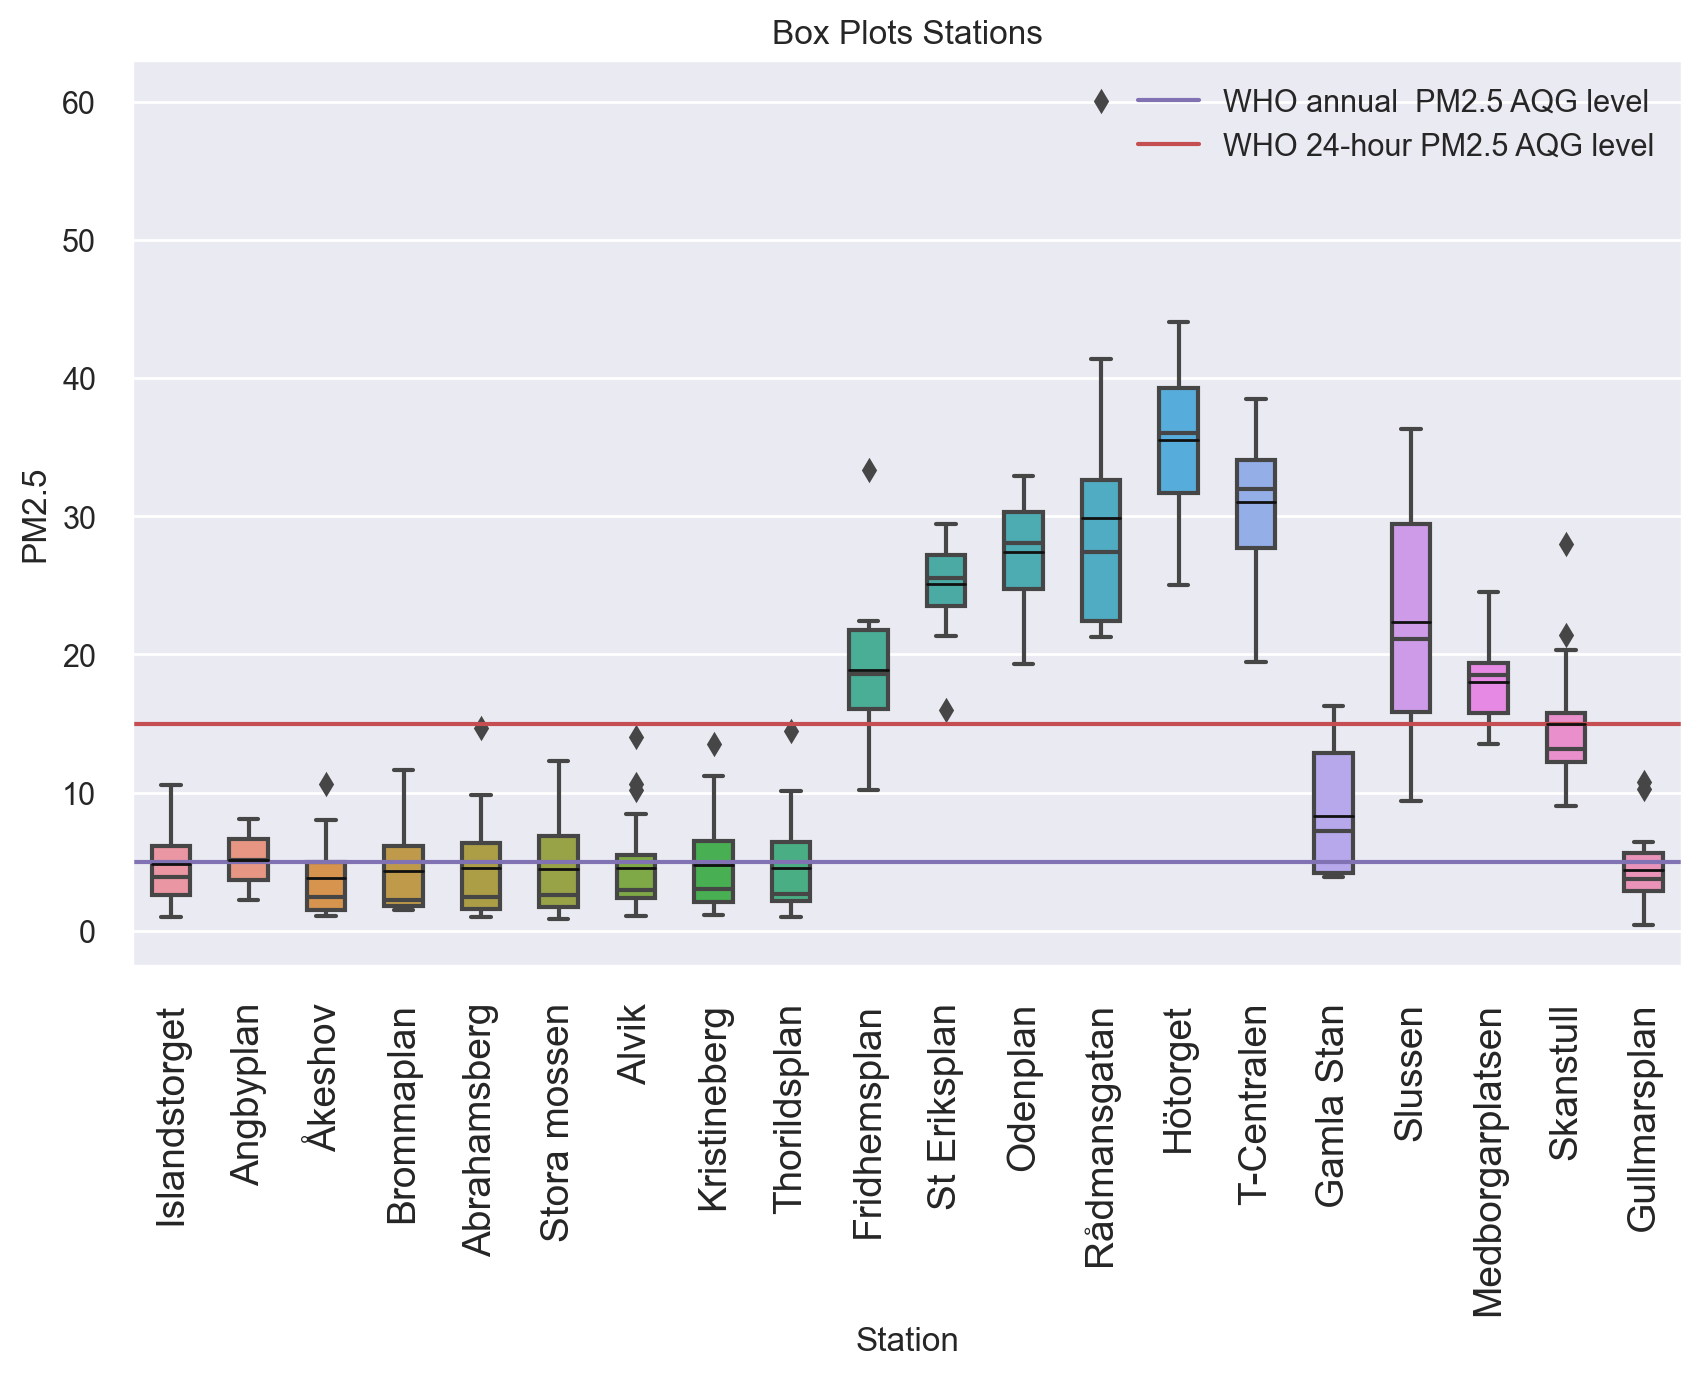

In [41]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(
    x='Station', 
    y=param, 
    data=s_df, 
    width=0.5, 
    order=get_green_line(), 
    showmeans=True,
    meanline=True, 
    meanprops={'color': '#111', 'ls': '-', 'lw': 1}
)

plt.axhline(5, label='WHO annual  PM2.5 AQG level', c='m')
plt.axhline(15, label='WHO 24-hour PM2.5 AQG level', c='r')

plt.legend()
plt.xticks(rotation=90, fontsize=14)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_lines({param}).pdf')

plt.show()

**Comments**

Hötorget, T-Centralen, and Rådmansgatan have the highest means.

### Quantiles and outliers

In [145]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
station_quantiles = s_df.groupby('Station').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

station_quantiles.to_csv(f'{fig_folder}/tables/station_quantiles({param}).csv')
station_quantiles[param].sort_values(by='outliers', ascending=False)

Q1         Q2         Q3        IQR  lowerLimit  \
Station                                                                    
Alvik              2.377000   2.968000   5.495000   3.118000   -2.300000   
Skanstull         12.240000  13.176000  15.735000   3.495000    6.997500   
Gullmarsplan       2.857125   3.729250   5.646667   2.789542   -1.327188   
Abrahamsberg       1.623667   2.426000   6.350000   4.726333   -5.465833   
Kristineberg       2.064000   3.004000   6.478750   4.414750   -4.558125   
Thorildsplan       2.170000   2.640000   6.418000   4.248000   -4.202000   
St Eriksplan      23.487500  25.514667  27.202000   3.714500   17.915750   
Rådmansgatan      22.420000  27.435000  32.610000  10.190000    7.135000   
Åkeshov            1.494000   2.448000   5.020000   3.526000   -3.795000   
Fridhemsplan      16.074000  18.566667  21.754583   5.680583    7.553125   
Islandstorget      2.602833   3.883000   6.127083   3.524250   -2.683542   
Hötorget          31.701000  36.015833  39.286125   7.585125   20.323313   
Odenplan          24.757333  28.098000  30.334167   5.576833   16.392083   
Gamla Stan         4.160000   7.250000  12.840000   8.680000   -8.860000   
Slussen           15.862500  21.095000  29.463125  13.600625   -4.538438   
Brommaplan         1.829000   2.265000   6.167500   4.338500   -4.678750   
Stora mossen       1.713333   2.594000   6.887500   5.174167   -6.047917   
T-Centralen       27.683333  31.975000  34.070000   6.386667   18.103333   
Angbyplan          3.698500   5.159000   6.619500   2.921000   -0.683000   
Medborgarplatsen  15.775000  18.538000  19.388000   3.613000   10.355500   

                  upperLimit  outliers  prcnt_outliers  count  
Station                                                        
Alvik              10.172000       3.0       15.000000     20  
Skanstull          20.977500       2.0       11.764706     17  
Gullmarsplan        9.830979       2.0       12.500000     16  
Abrahamsberg       13.439500       1.0        9.090909     11  
Kristineberg       13.100875       1.0        5.000000     20  
Thorildsplan       12.790000       1.0        5.882353     17  
St Eriksplan       32.773750       1.0        5.000000     20  
Rådmansgatan       47.895000       1.0        5.882353     17  
Åkeshov            10.309000       1.0       11.111111      9  
Fridhemsplan       30.275458       1.0        5.000000     20  
Islandstorget      11.413458       0.0        0.000000      4  
Hötorget           50.663812       0.0        0.000000     16  
Odenplan           38.699417       0.0        0.000000     27  
Gamla Stan         25.860000       0.0        0.000000     17  
Slussen            49.864063       0.0        0.000000     18  
Brommaplan         12.675250       0.0        0.000000     11  
Stora mossen       14.648750       0.0        0.000000     11  
T-Centralen        43.650000       0.0        0.000000     17  
Angbyplan          11.001000       0.0        0.000000      2  
Medborgarplatsen   24.807500       0.0        0.000000     17

**Comment**

Some stations have outliers. What happened during these sessions?

In [88]:
outlier_ids = print_outliers(s_df, station_quantiles, param)

=== OUTLIERS ===
Abrahamsberg:
	20211004-2 - PM2.5 = 14.66

Alvik:
	20211004-2 - PM2.5 = 14.0
	20211011-2 - PM2.5 = 10.62
	20211006-2 - PM2.5 = 10.18

Fridhemsplan:
	20211013-1 - PM2.5 = 33.31

Gullmarsplan:
	20211011-1 - PM2.5 = 10.78
	20211006-1 - PM2.5 = 10.28

Kristineberg:
	20211004-2 - PM2.5 = 13.5

Rådmansgatan:
	20210929-1 - PM2.5 = 60.05

Skanstull:
	20210930-3 - PM2.5 = 27.99
	20211004-1 - PM2.5 = 21.44

St Eriksplan:
	20211005-2 - PM2.5 = 16.0

Thorildsplan:
	20211004-2 - PM2.5 = 14.47

Åkeshov:
	20211004-2 - PM2.5 = 10.6

Unique outliers: ['20210929-1', '20210930-3', '20211004-1', '20211004-2', '20211005-2', '20211006-1', '20211006-2', '20211011-1', '20211011-2', '20211013-1']


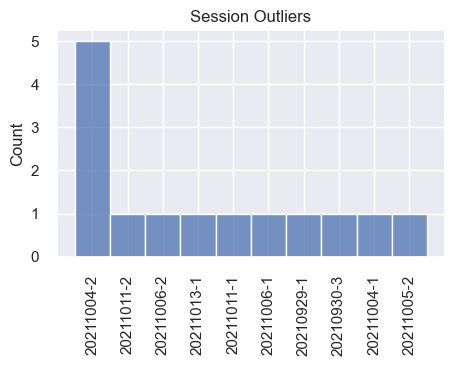

In [96]:
fig, ax = plt.subplots(figsize=[5, 3], dpi=100)

sns.histplot(outlier_ids)
plt.title('Session Outliers')
plt.xticks(rotation=90)
plt.show()

**Comment**

These sessions are worth examining and comparing with other sources. Especially session 20211004-2, as it contains 5 outliers within the same session!

## Rush and off hours

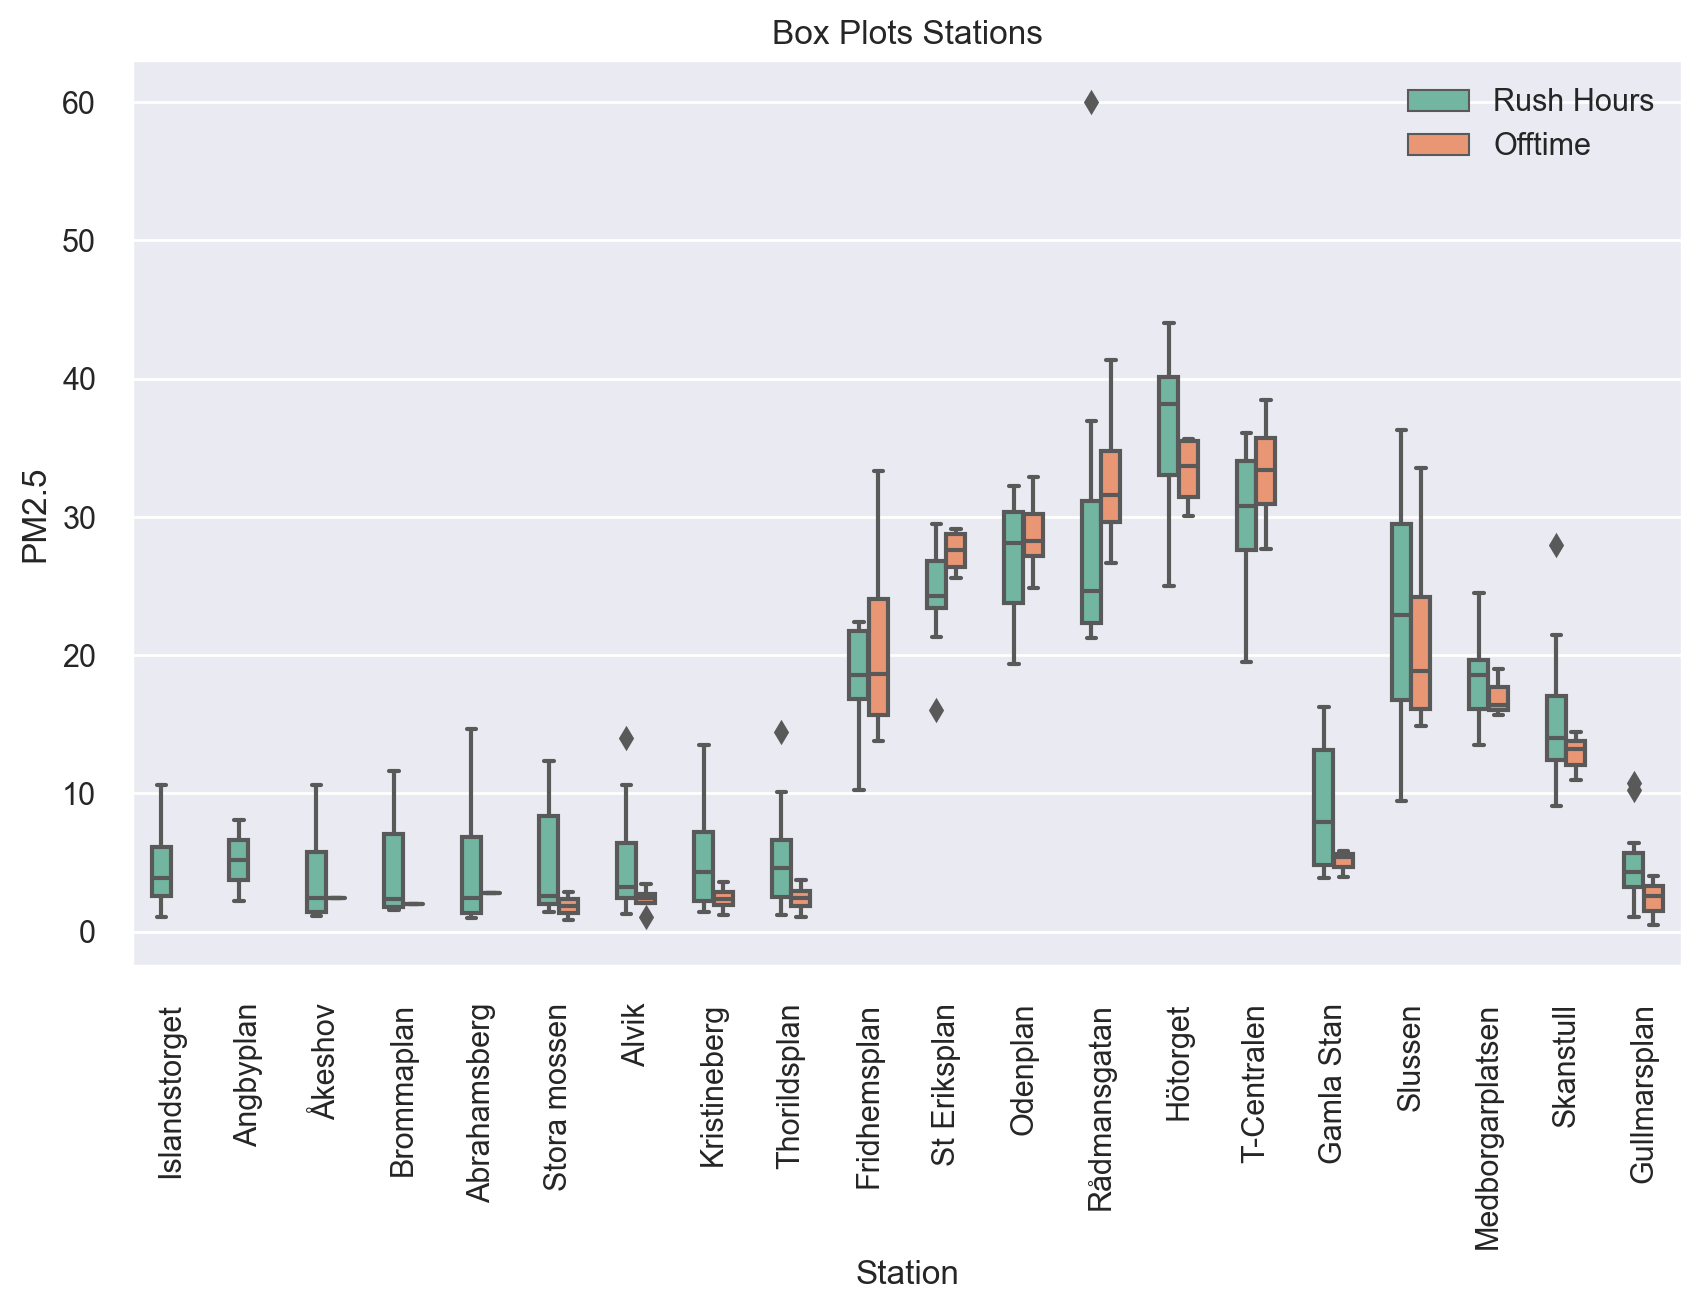

In [97]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.copy()
plot_df['Period'] = plot_df['Period'].apply(lambda x: 'Rush Hours' if x in ['Evening rush', 'Morning rush'] else x)

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2"
)

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_rush_vs_offtime({param}).pdf')

plt.show()

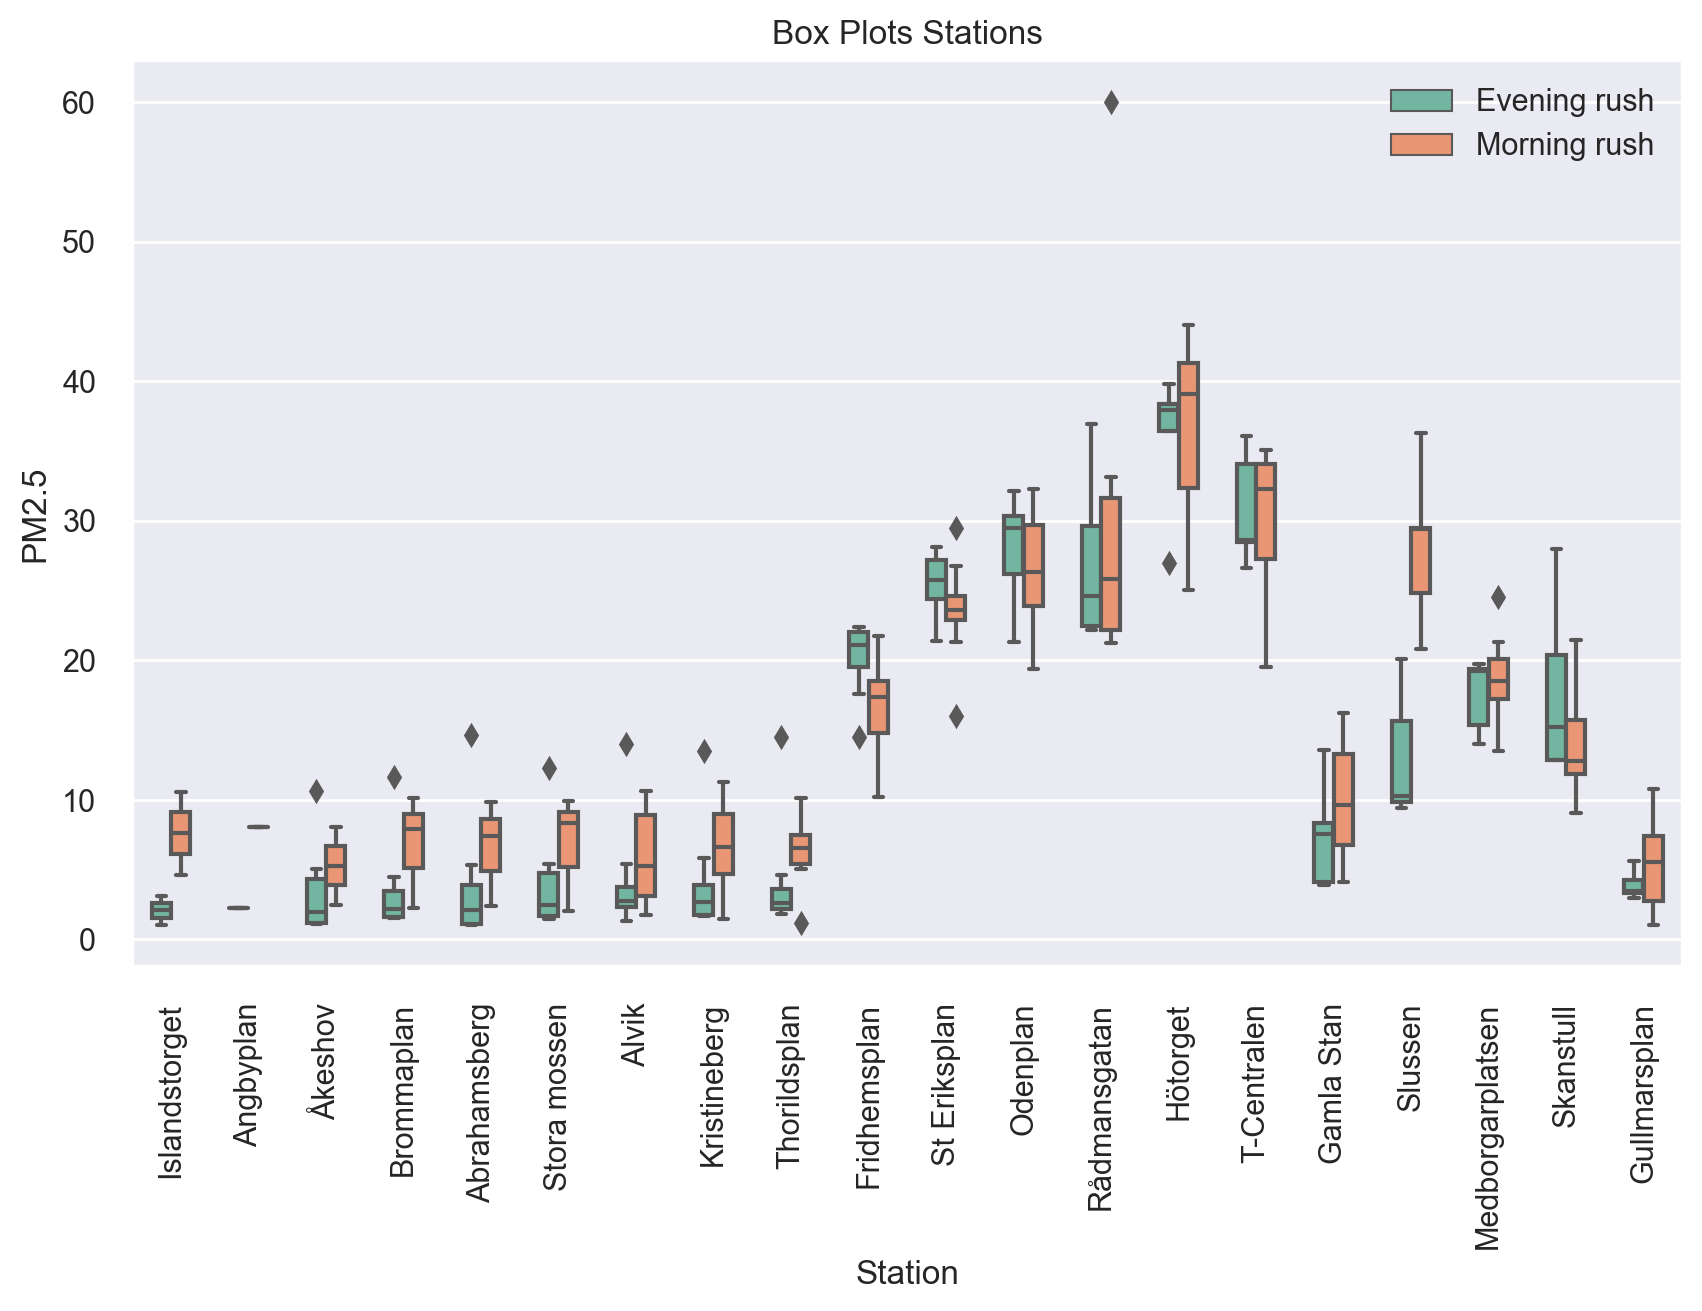

In [98]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.loc[s_df['Period'] != 'Offtime']

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2"
)

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_morning_evening_rush({param}).pdf')

plt.show()

### Histograms

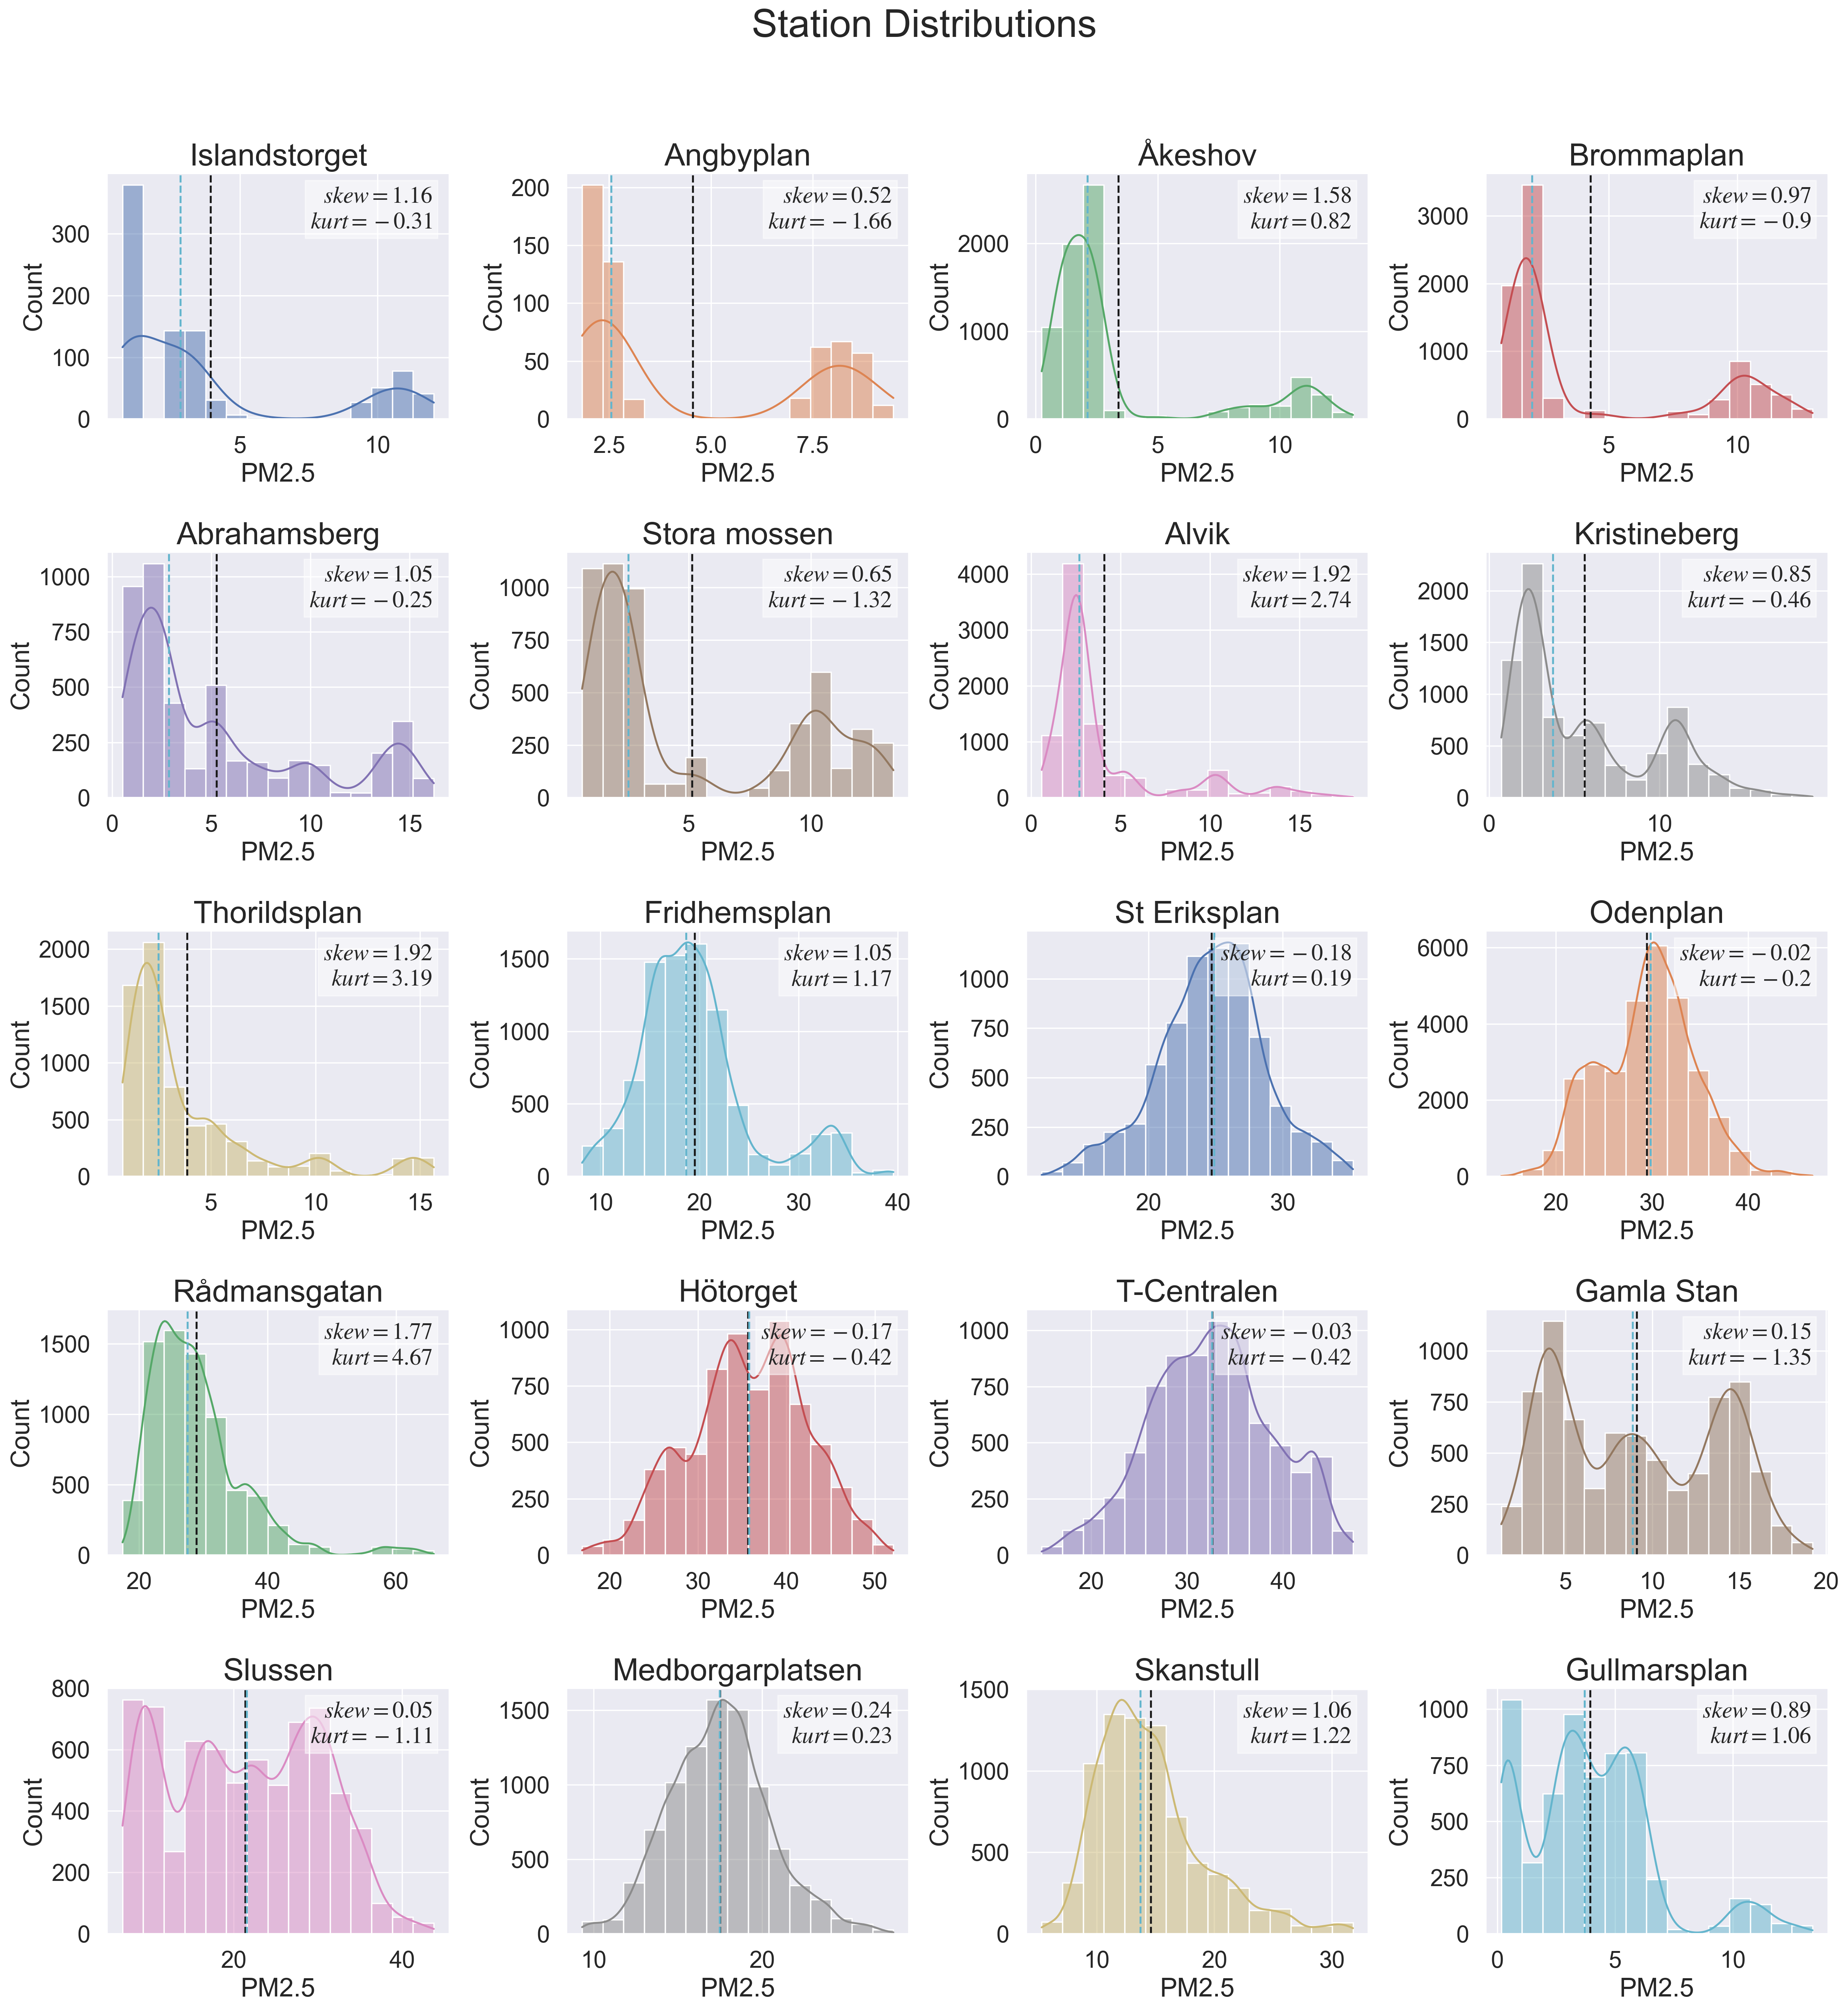

In [157]:
plot_distributions(
    df=r_df, 
    dist_col='Station', 
    title='Station Distributions', 
    fig_name=f'{fig_folder}/distributions({param}).pdf',
    param=param,
    with_textbox=True,
    column_count=4,
    bins=15
)

### Normal distribution

In [144]:
normal = r_df.groupby('Station').agg({param: [skew, kurtosis]})
normal[param].to_csv(f'{fig_folder}/tables/normal({param}).csv')

normal

PM2.5          
                      skew  kurtosis
Station                             
Abrahamsberg      1.048203 -0.245440
Alvik             1.923020  2.741124
Angbyplan         0.524323 -1.657415
Brommaplan        0.969021 -0.898802
Fridhemsplan      1.052310  1.170357
Gamla Stan        0.149744 -1.345074
Gullmarsplan      0.891134  1.057893
Hötorget         -0.167546 -0.417548
Islandstorget     1.155322 -0.313787
Kristineberg      0.846879 -0.458000
Medborgarplatsen  0.239496  0.227953
Odenplan         -0.023853 -0.197537
Rådmansgatan      1.768494  4.673342
Skanstull         1.063096  1.223893
Slussen           0.052867 -1.109098
St Eriksplan     -0.183082  0.186151
Stora mossen      0.650203 -1.320170
T-Centralen      -0.025510 -0.422461
Thorildsplan      1.923166  3.194634
Åkeshov           1.581402  0.822684

#### QQ Plots

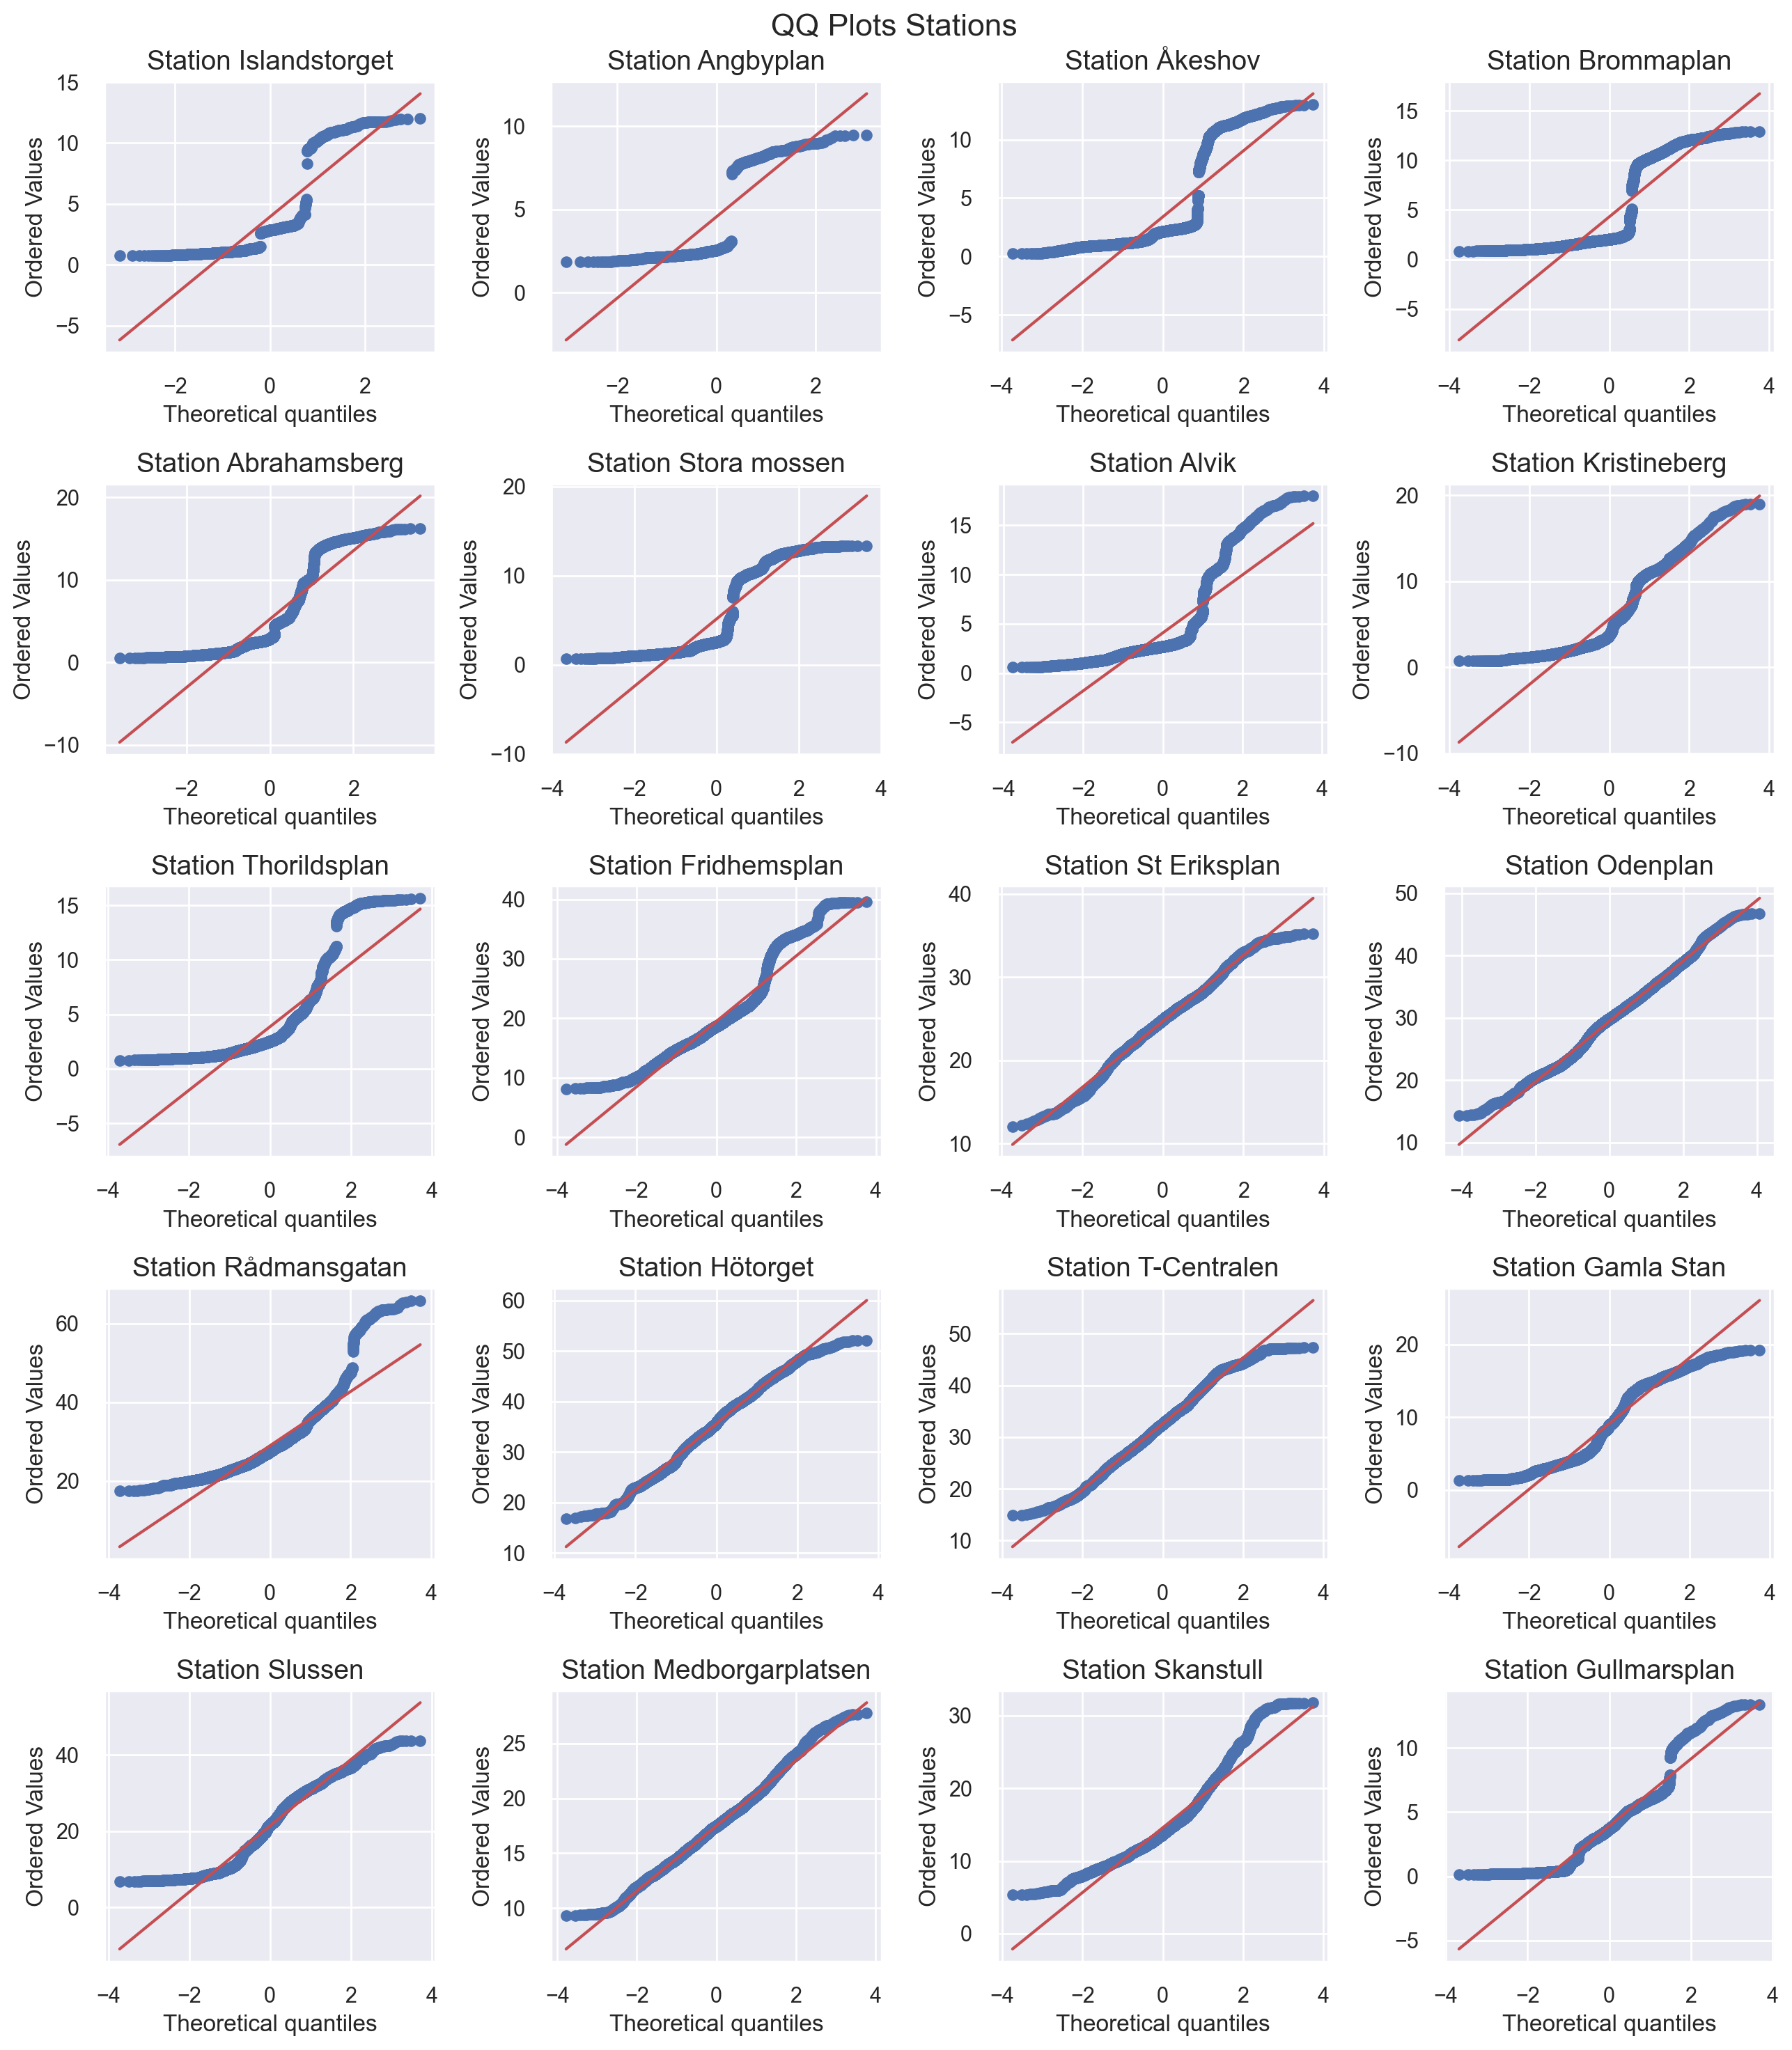

In [338]:
plot_QQ_plots(
    r_df, 
    title='QQ Plots Stations', 
    param=param, 
    fig_name=f'{fig_folder}/QQPlots({param}).pdf',
    col_count=4,
    row_count=5,
    label='Station',
    size=(13, 15)
)

### Sensor diffs

How much do the sensor means per session per station differ? Compute standard deviation per session per station.

In [174]:
station_diffs = {}

for session_id, grp in r_df.groupby('Session Id'):
    for station, station_grp in grp.groupby('Station'):
        if station not in station_diffs:
            station_diffs[station] = []
            
        # Compute std
        station_diffs[station].append(sample_std(station_grp[param].values))
            
# Convert into one long array and make a histogram
mean_station_diffs = {s: np.mean(v) for s, v in station_diffs.items()}
mean_station_diffs

station_diffs_df = pd.DataFrame(list(mean_station_diffs.items()), columns=['station', 'mean sensor std'])
station_diffs_df['order'] = [get_green_line().index(station) for station in mean_station_diffs.keys()]

print(f'Total mean sensor diff: {station_diffs_df["mean sensor std"].mean()}')

station_diffs_df.to_csv(f'{fig_folder}/tables/sensors_diffs_per_station({param}).csv')

station_diffs_df.sort_values(by=['mean sensor std'], ascending=False)

Total mean sensor diff: 1.466236069988657


station  mean sensor std  order
2           Hötorget         3.934129     13
8        T-Centralen         3.361600     14
15      St Eriksplan         2.754218     10
5       Rådmansgatan         2.747722     12
4           Odenplan         2.567057     11
7            Slussen         2.566548     16
12      Fridhemsplan         2.037218      9
3   Medborgarplatsen         1.844523     17
6          Skanstull         1.647639     18
0         Gamla Stan         1.035677     15
9       Abrahamsberg         0.645219      4
13     Islandstorget         0.568537      0
14      Kristineberg         0.558587      7
1       Gullmarsplan         0.545975     19
17      Thorildsplan         0.503136      8
10             Alvik         0.465381      6
18           Åkeshov         0.413297      2
16      Stora mossen         0.386574      5
19         Angbyplan         0.385657      1
11        Brommaplan         0.356028      3

### How much do every single sensor differ per station?

In [175]:
diffs = {}

for station, grp in r_df.groupby('Station'):
    diffs[station] = {}
    for sensor, sensor_grp in grp.groupby('Sensor'):
        diffs[station][sensor] = sample_std(sensor_grp[param].values)

diffs_df = pd.concat([pd.DataFrame(diffs[s].values(), index=diffs[s].keys(), columns=[s]).T for s in r_df['Station'].unique()])

diffs_df.loc['Avg'] = diffs_df.mean()

diffs_df.to_csv(f'{fig_folder}/tables/sensor_diff_per_station({param}).csv')

diffs_df

1          2         3         4         5         6  \
Islandstorget     3.211636   3.327906  3.792090  3.326726  3.991383  0.352996   
Angbyplan         0.103136   2.943800  0.266006  0.217073  0.121511       NaN   
Åkeshov           3.473360   3.892637  3.330701  3.808935  3.719053       NaN   
Brommaplan        4.162947   3.919091  4.233889  4.354806  4.359644  0.886205   
Abrahamsberg      4.974648   4.003359  5.129500  5.264613  4.962984  3.179298   
Stora mossen      4.322610   4.176057  4.442939  4.158027  4.572867  1.129900   
Alvik             3.615531   3.384691  3.914462  4.322196  3.965400  4.789921   
Kristineberg      4.222561   4.100721  4.430787  4.285757  4.542133  4.221945   
Thorildsplan      3.596889   3.526476  4.170309  4.279091  3.951474  5.437646   
Fridhemsplan      6.592349   6.477304  6.637651  6.405331  6.186111  2.079107   
St Eriksplan      3.739309   4.109427  3.592675  3.899974  3.240527  3.271821   
Odenplan          3.861561   5.145351  3.658167  3.979487  3.385664  3.665386   
Rådmansgatan      3.577910   8.668129  3.576100  5.284563  2.719432  2.071747   
Hötorget          5.814305   5.733901  5.653610  5.301326  3.739305  4.396209   
T-Centralen       3.674931   5.526434  5.942806  4.953943  3.302212  4.255966   
Gamla Stan        5.111991   4.814662  5.689908  4.432985  5.018309  5.413300   
Slussen           8.874653  10.164860  9.170583  9.347808  8.563737  9.035944   
Medborgarplatsen  3.112649   3.316503  2.835944  2.186402  3.002374  2.141532   
Skanstull         5.170299   6.104303  3.956903  6.349599  3.972025  4.562252   
Gullmarsplan      1.495907   2.490693  1.562963  1.723835  1.459728  1.191967   
Avg               4.135459   4.791315  4.299400  4.394124  3.938794  3.449063   

                         B         A         C         D         E  
Islandstorget     0.193980       NaN       NaN       NaN       NaN  
Angbyplan         0.222070       NaN       NaN       NaN       NaN  
Åkeshov           3.095617  0.763321  0.502801  0.618481  0.433365  
Brommaplan        1.935534  0.396169  0.368404  0.393666  0.452739  
Abrahamsberg      2.132978  0.552404  0.524485  0.636494  0.570312  
Stora mossen      2.364820  0.732751  0.434401  0.630076  0.619683  
Alvik             2.059057  1.113315  1.395966  1.590813  1.459765  
Kristineberg      2.289297  1.629217  2.152977  1.876298  1.977068  
Thorildsplan      2.078409  1.292157  1.680511  1.597459  1.461563  
Fridhemsplan      3.624775  3.982647  4.531233  2.342707  3.652811  
St Eriksplan      2.422835  2.005176  3.392008  2.127479  2.721049  
Odenplan          3.886975  3.289066  3.317498  2.622258  3.381406  
Rådmansgatan      7.840622  5.602798  7.543046  6.397265  8.138053  
Hötorget          5.839084  8.174895  7.062115  4.919497  6.831521  
T-Centralen       6.891009  5.807254  5.770219  5.162003  6.366759  
Gamla Stan        3.589185  3.183958  4.237687  3.497978  3.687728  
Slussen           7.832109  6.623500  7.987723  6.976425  8.147521  
Medborgarplatsen  2.530274  4.053206  2.715570  2.226126  1.977148  
Skanstull         4.281109  3.365592  2.236536  2.201035  2.585218  
Gullmarsplan      3.032066  3.507322  3.119415  2.817734  3.007711  
Avg               3.407090  3.115264  3.276255  2.701877  3.192857

# Focus on Hötorget

In [74]:
focus_s_df = s_df.loc[s_df.Station == 'Hötorget'].sort_values(by=['Timestamp'])
focus_r_df = r_df.loc[r_df.Station == 'Hötorget'].sort_values(by=['Sensor'])

### Box plots sensors

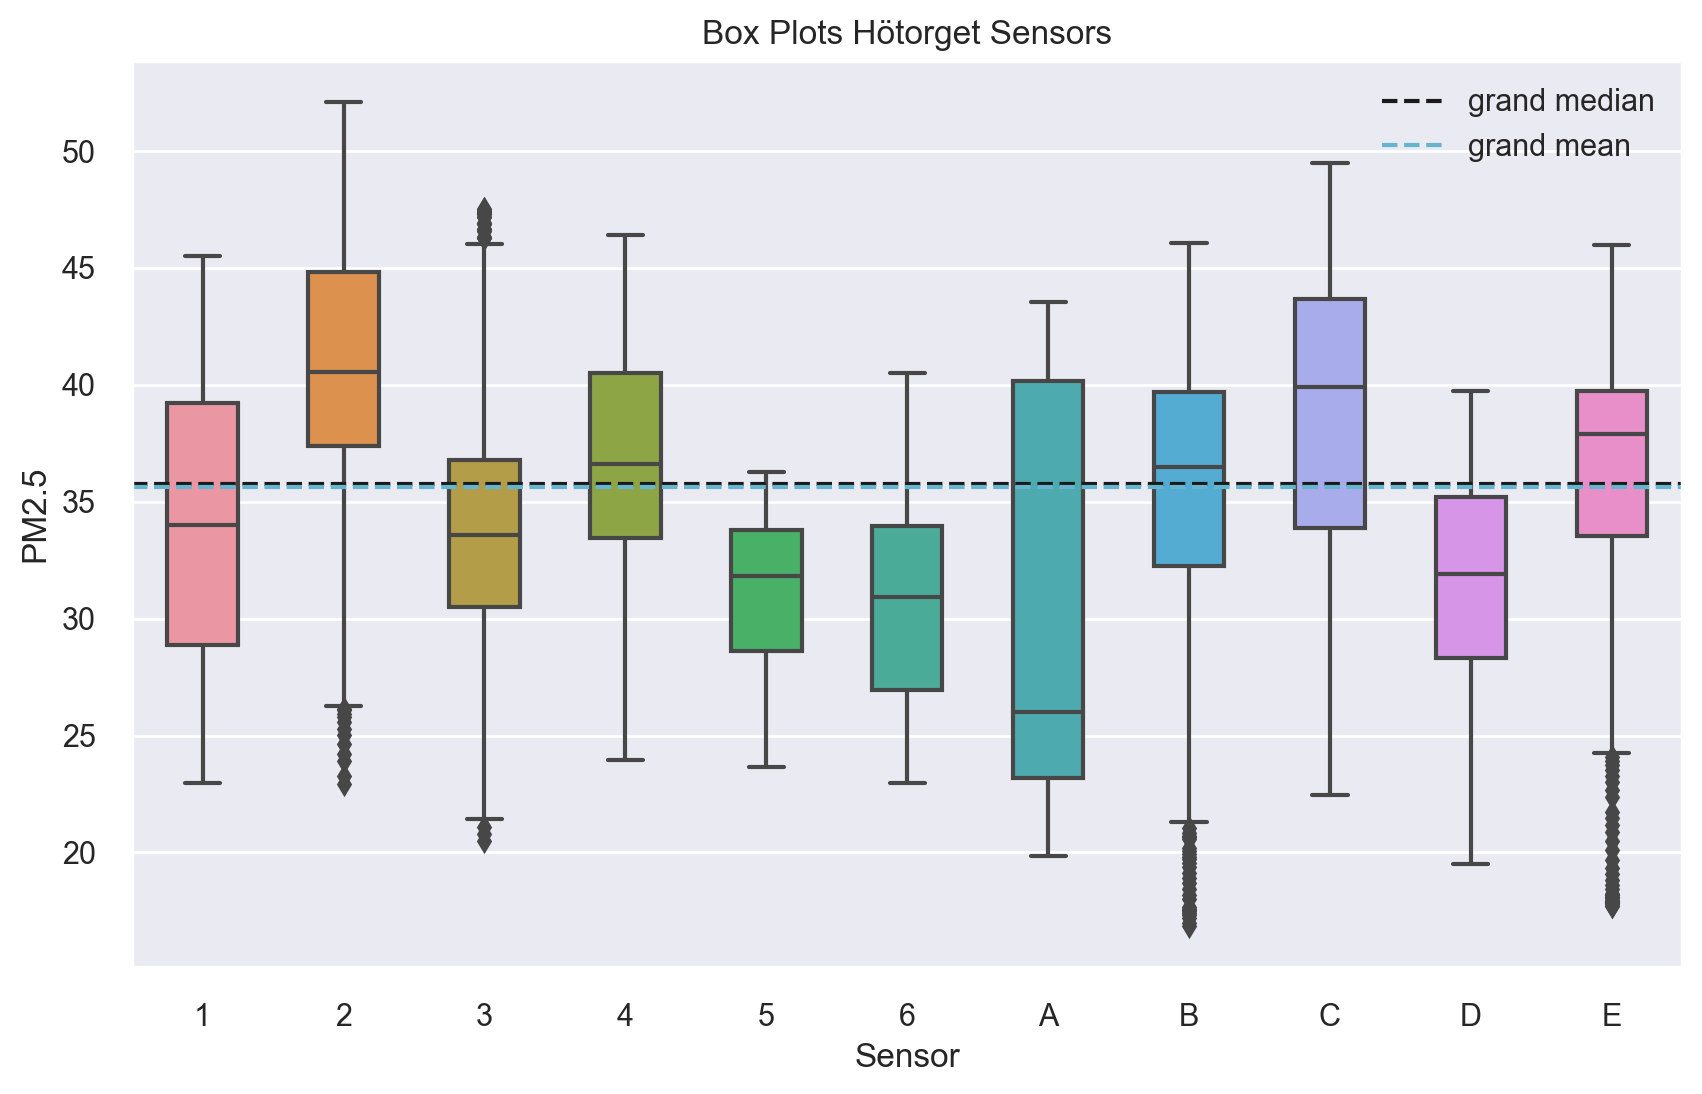

In [75]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Sensor', y=param, data=focus_r_df, width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Hötorget Sensors')
plt.savefig(f'{fig_folder}/Hotorget_box_plot_sensor({param}).pdf')
plt.show()

In [76]:
station_diffs['Hötorget']

[4.0736740178738104,
 4.836107249572132,
 4.3176641444329755,
 4.200456895111019,
 4.095857392192398,
 3.6546224331469284,
 3.577856861524022,
 2.8958005360981685,
 4.630738192358802,
 3.2499391624067093,
 2.2882067383528177,
 5.190721846190268,
 4.796964758970221,
 4.125968110044006,
 3.4485611272785137,
 3.5629251266539566]

In [381]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = focus_r_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles

PM2.5                                                           \
             Q1      Q2       Q3      IQR lowerLimit upperLimit outliers   
Sensor                                                                     
1       28.8850  33.990  39.2350  10.3500   13.36000   54.76000      0.0   
2       37.3800  40.530  44.8150   7.4350   26.22750   55.96750     12.0   
3       30.5150  33.590  36.7850   6.2700   21.11000   46.19000     27.0   
4       33.4300  36.600  40.5100   7.0800   22.81000   51.13000      0.0   
5       28.6300  31.840  33.8100   5.1800   20.86000   41.58000      0.0   
6       26.9600  30.930  33.9750   7.0150   16.43750   44.49750      0.0   
A       23.2025  26.010  40.1850  16.9825   -2.27125   65.65875      0.0   
B       32.2700  36.480  39.7000   7.4300   21.12500   50.84500     27.0   
C       33.8975  39.925  43.6825   9.7850   19.22000   58.36000      0.0   
D       28.3350  31.920  35.2050   6.8700   18.03000   45.51000      0.0   
E       33.5375  37.900  39.7425   6.2050   24.23000   49.05000     40.0   

                             
       prcnt_outliers count  
Sensor                       
1            0.000000   506  
2            0.935308  1283  
3            3.233533   835  
4            0.000000   773  
5            0.000000   345  
6            0.000000   271  
A            0.000000   218  
B            2.072141  1303  
C            0.000000   424  
D            0.000000   423  
E            9.345794   428

### Box plot sessions

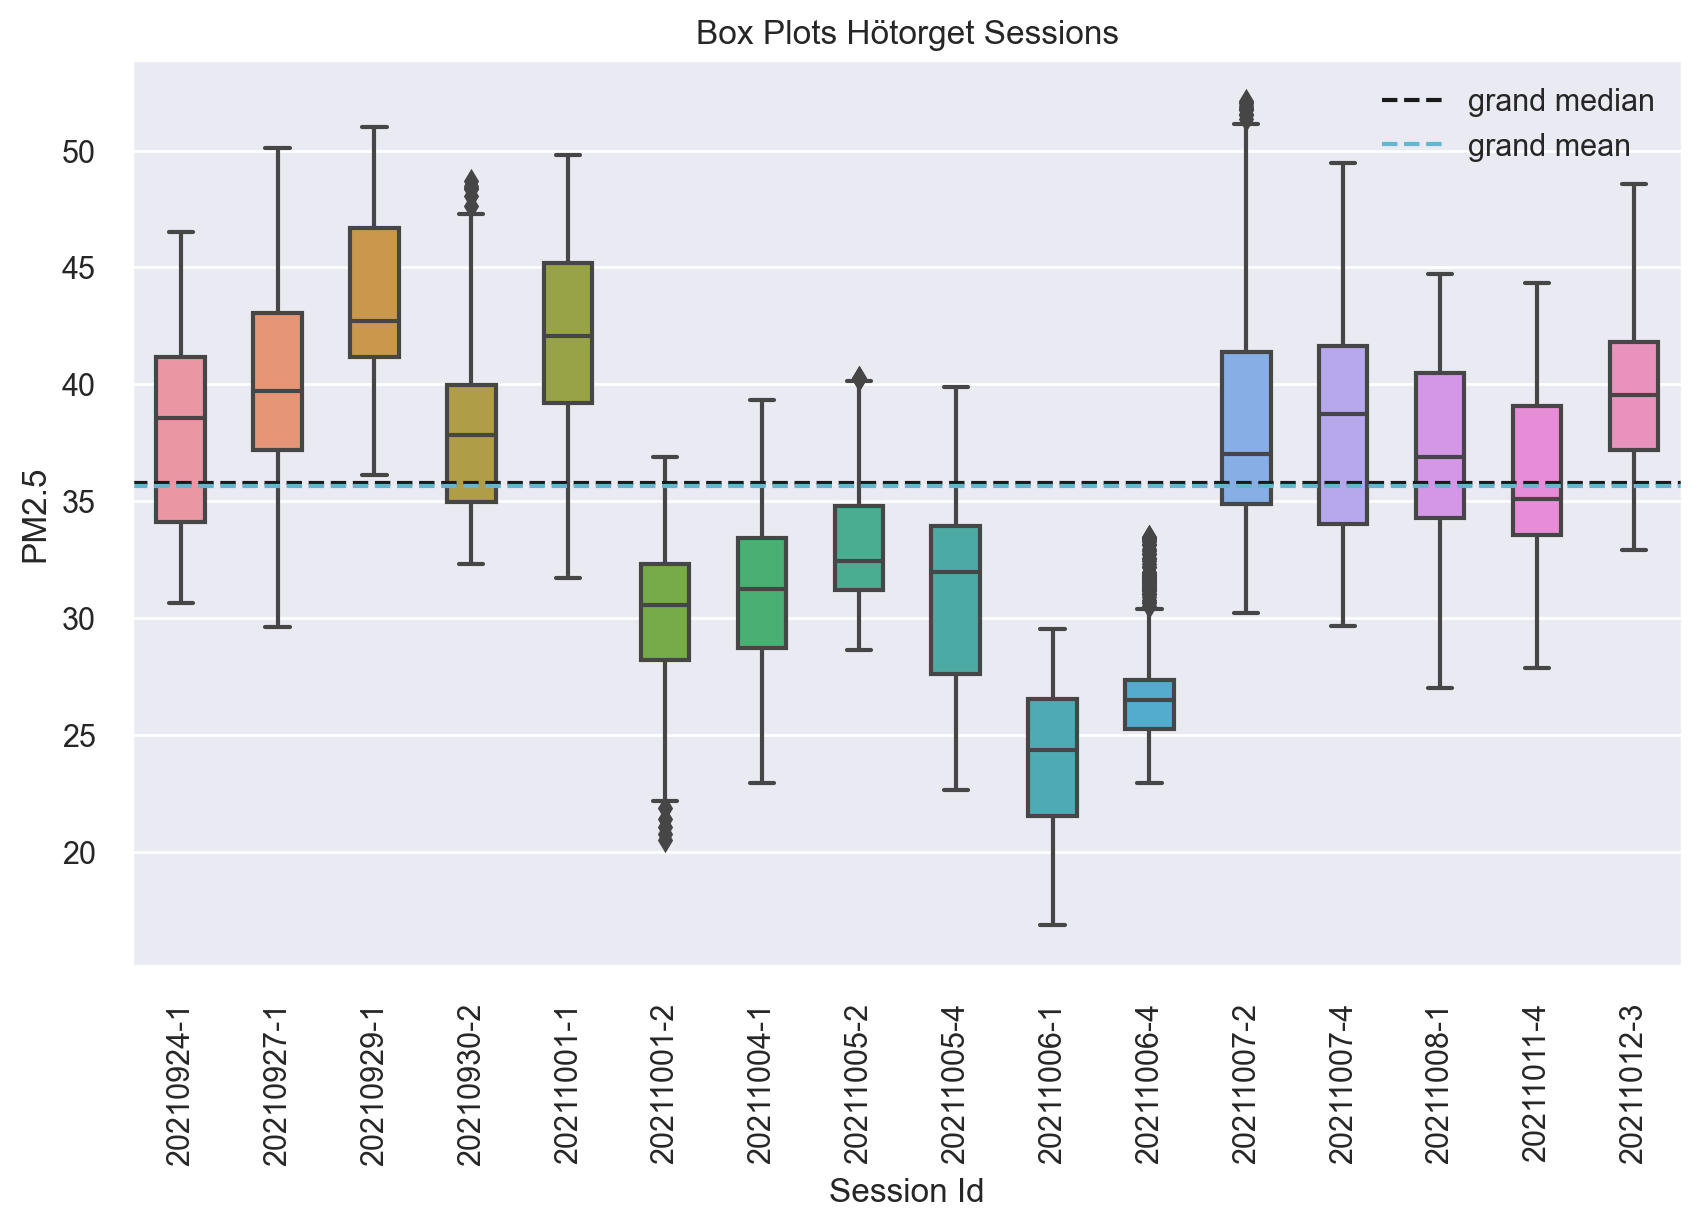

In [394]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Session Id', y=param, data=focus_r_df.sort_values(by=['Timestamp']), width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.xticks(rotation=90)
plt.legend()
plt.title('Box Plots Hötorget Sessions')
plt.savefig(f'{fig_folder}/Hotorget_box_plot_sessions({param}).pdf')
plt.show()

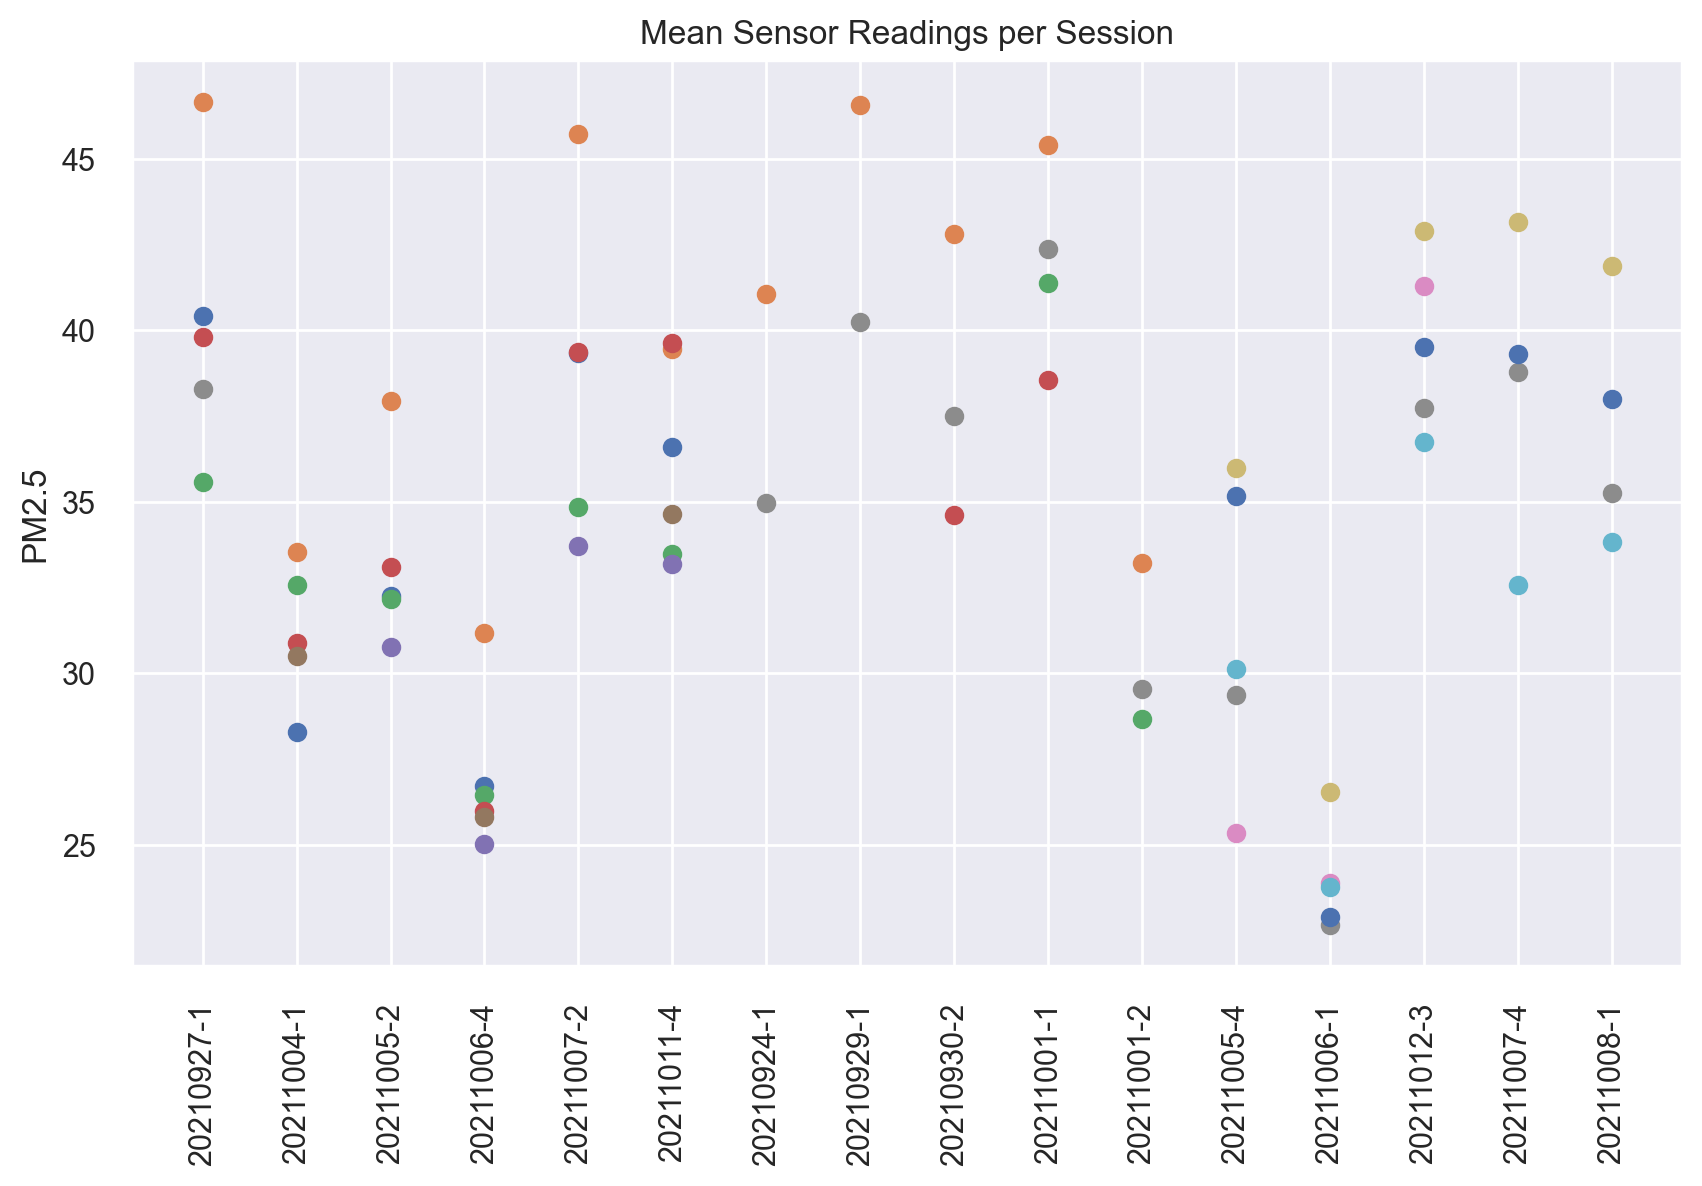

In [154]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

session_sensors = {}
for sensor, grp in focus_r_df.groupby('Sensor'):
    if sensor not in session_sensors:
        session_sensors[sensor] = {}
        
    for session_id, session_grp in grp.groupby('Session Id'):
        session_sensors[sensor][session_id] = session_grp[param].mean()
        
for sensor, data in session_sensors.items():
    ax.scatter(data.keys(), data.values(), label=sensor)
    
plt.xticks(rotation=90)
#plt.legend()
plt.title('Mean Sensor Readings per Session')
plt.savefig(f'{fig_folder}/Hotorget_mean_sensor_reading_per_session({param}).pdf')
plt.ylabel(param)

plt.show()

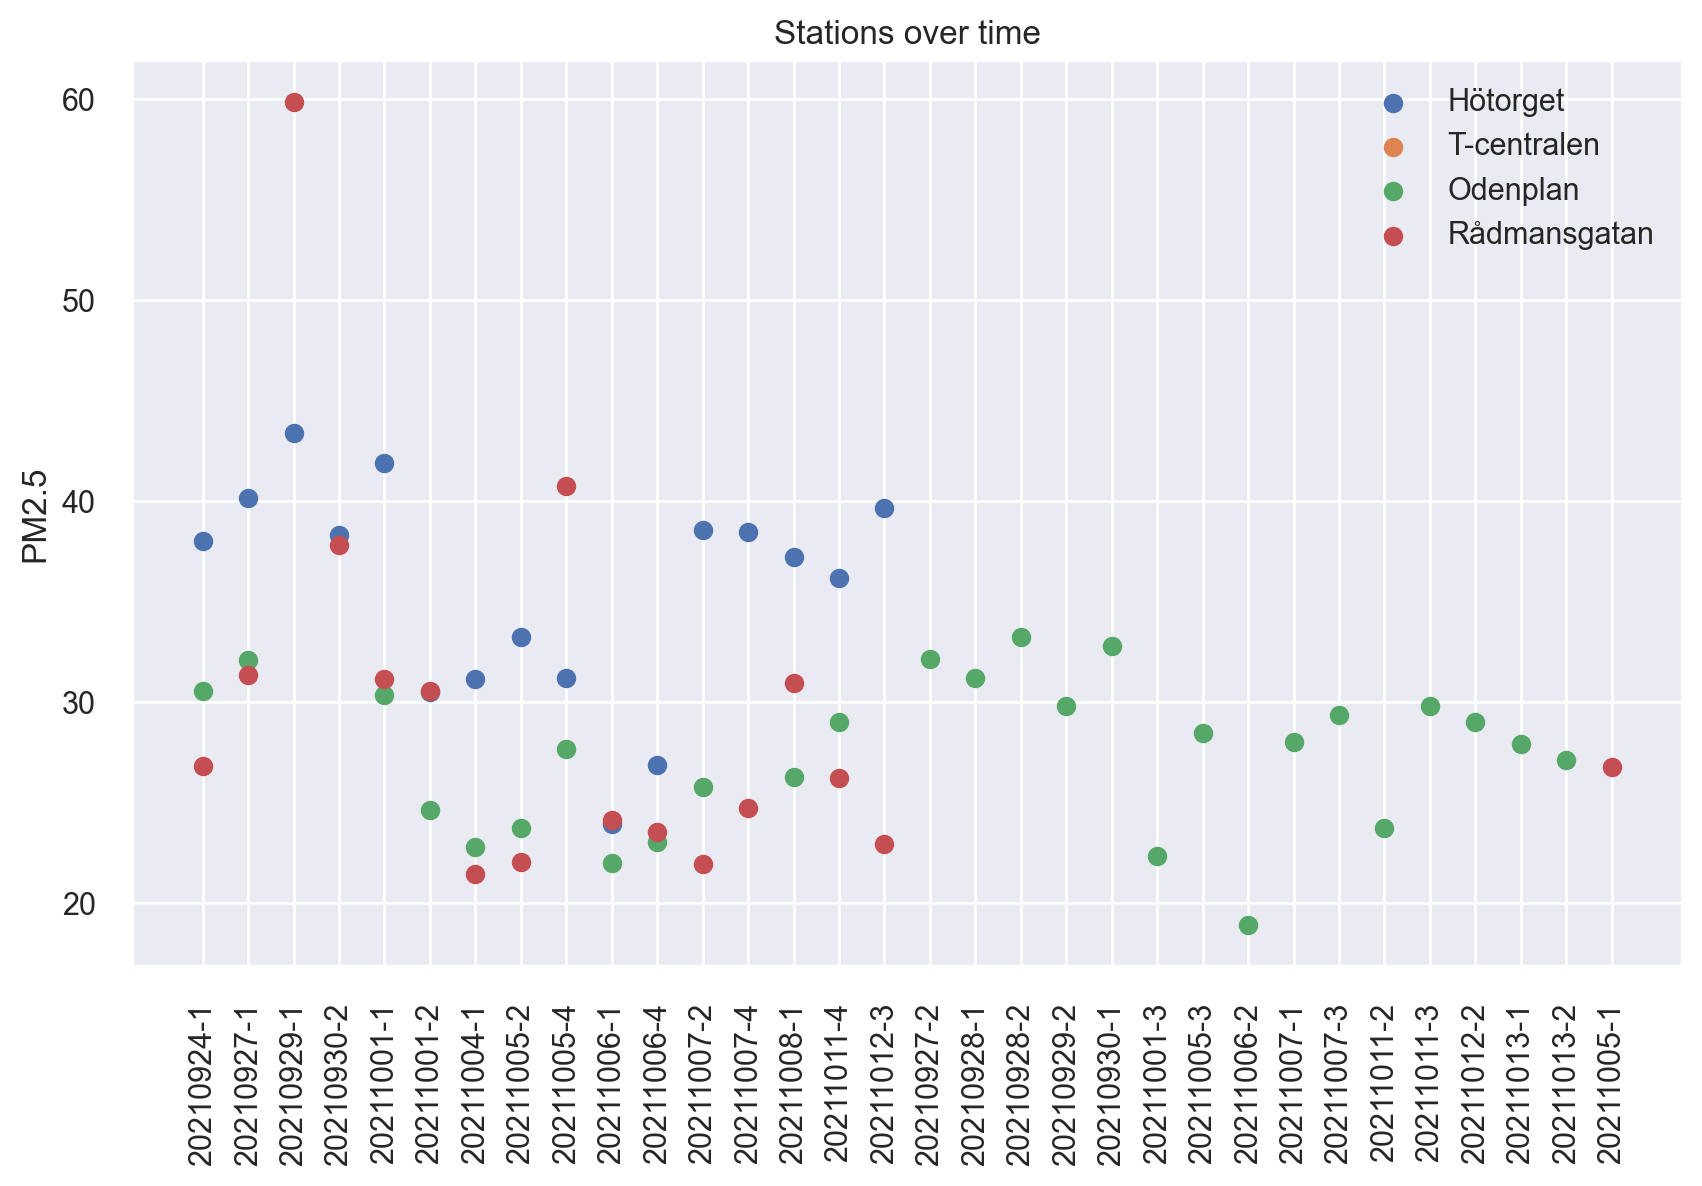

In [211]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

for station in ['Hötorget', 'T-centralen', 'Odenplan', 'Rådmansgatan']:
    session_means = {}
    for session, grp in r_df[r_df['Station'] == station].groupby('Session Id'):
        session_means[session] = grp[param].mean()

    ax.scatter(session_means.keys(), session_means.values(), label=station)
    
plt.xticks(rotation=90)
plt.legend()
#plt.legend()
plt.title('Stations over time')
plt.savefig(f'{fig_folder}/focus_dfs_over_time({param}).pdf')
plt.ylabel(param)

plt.show()

### Distribution

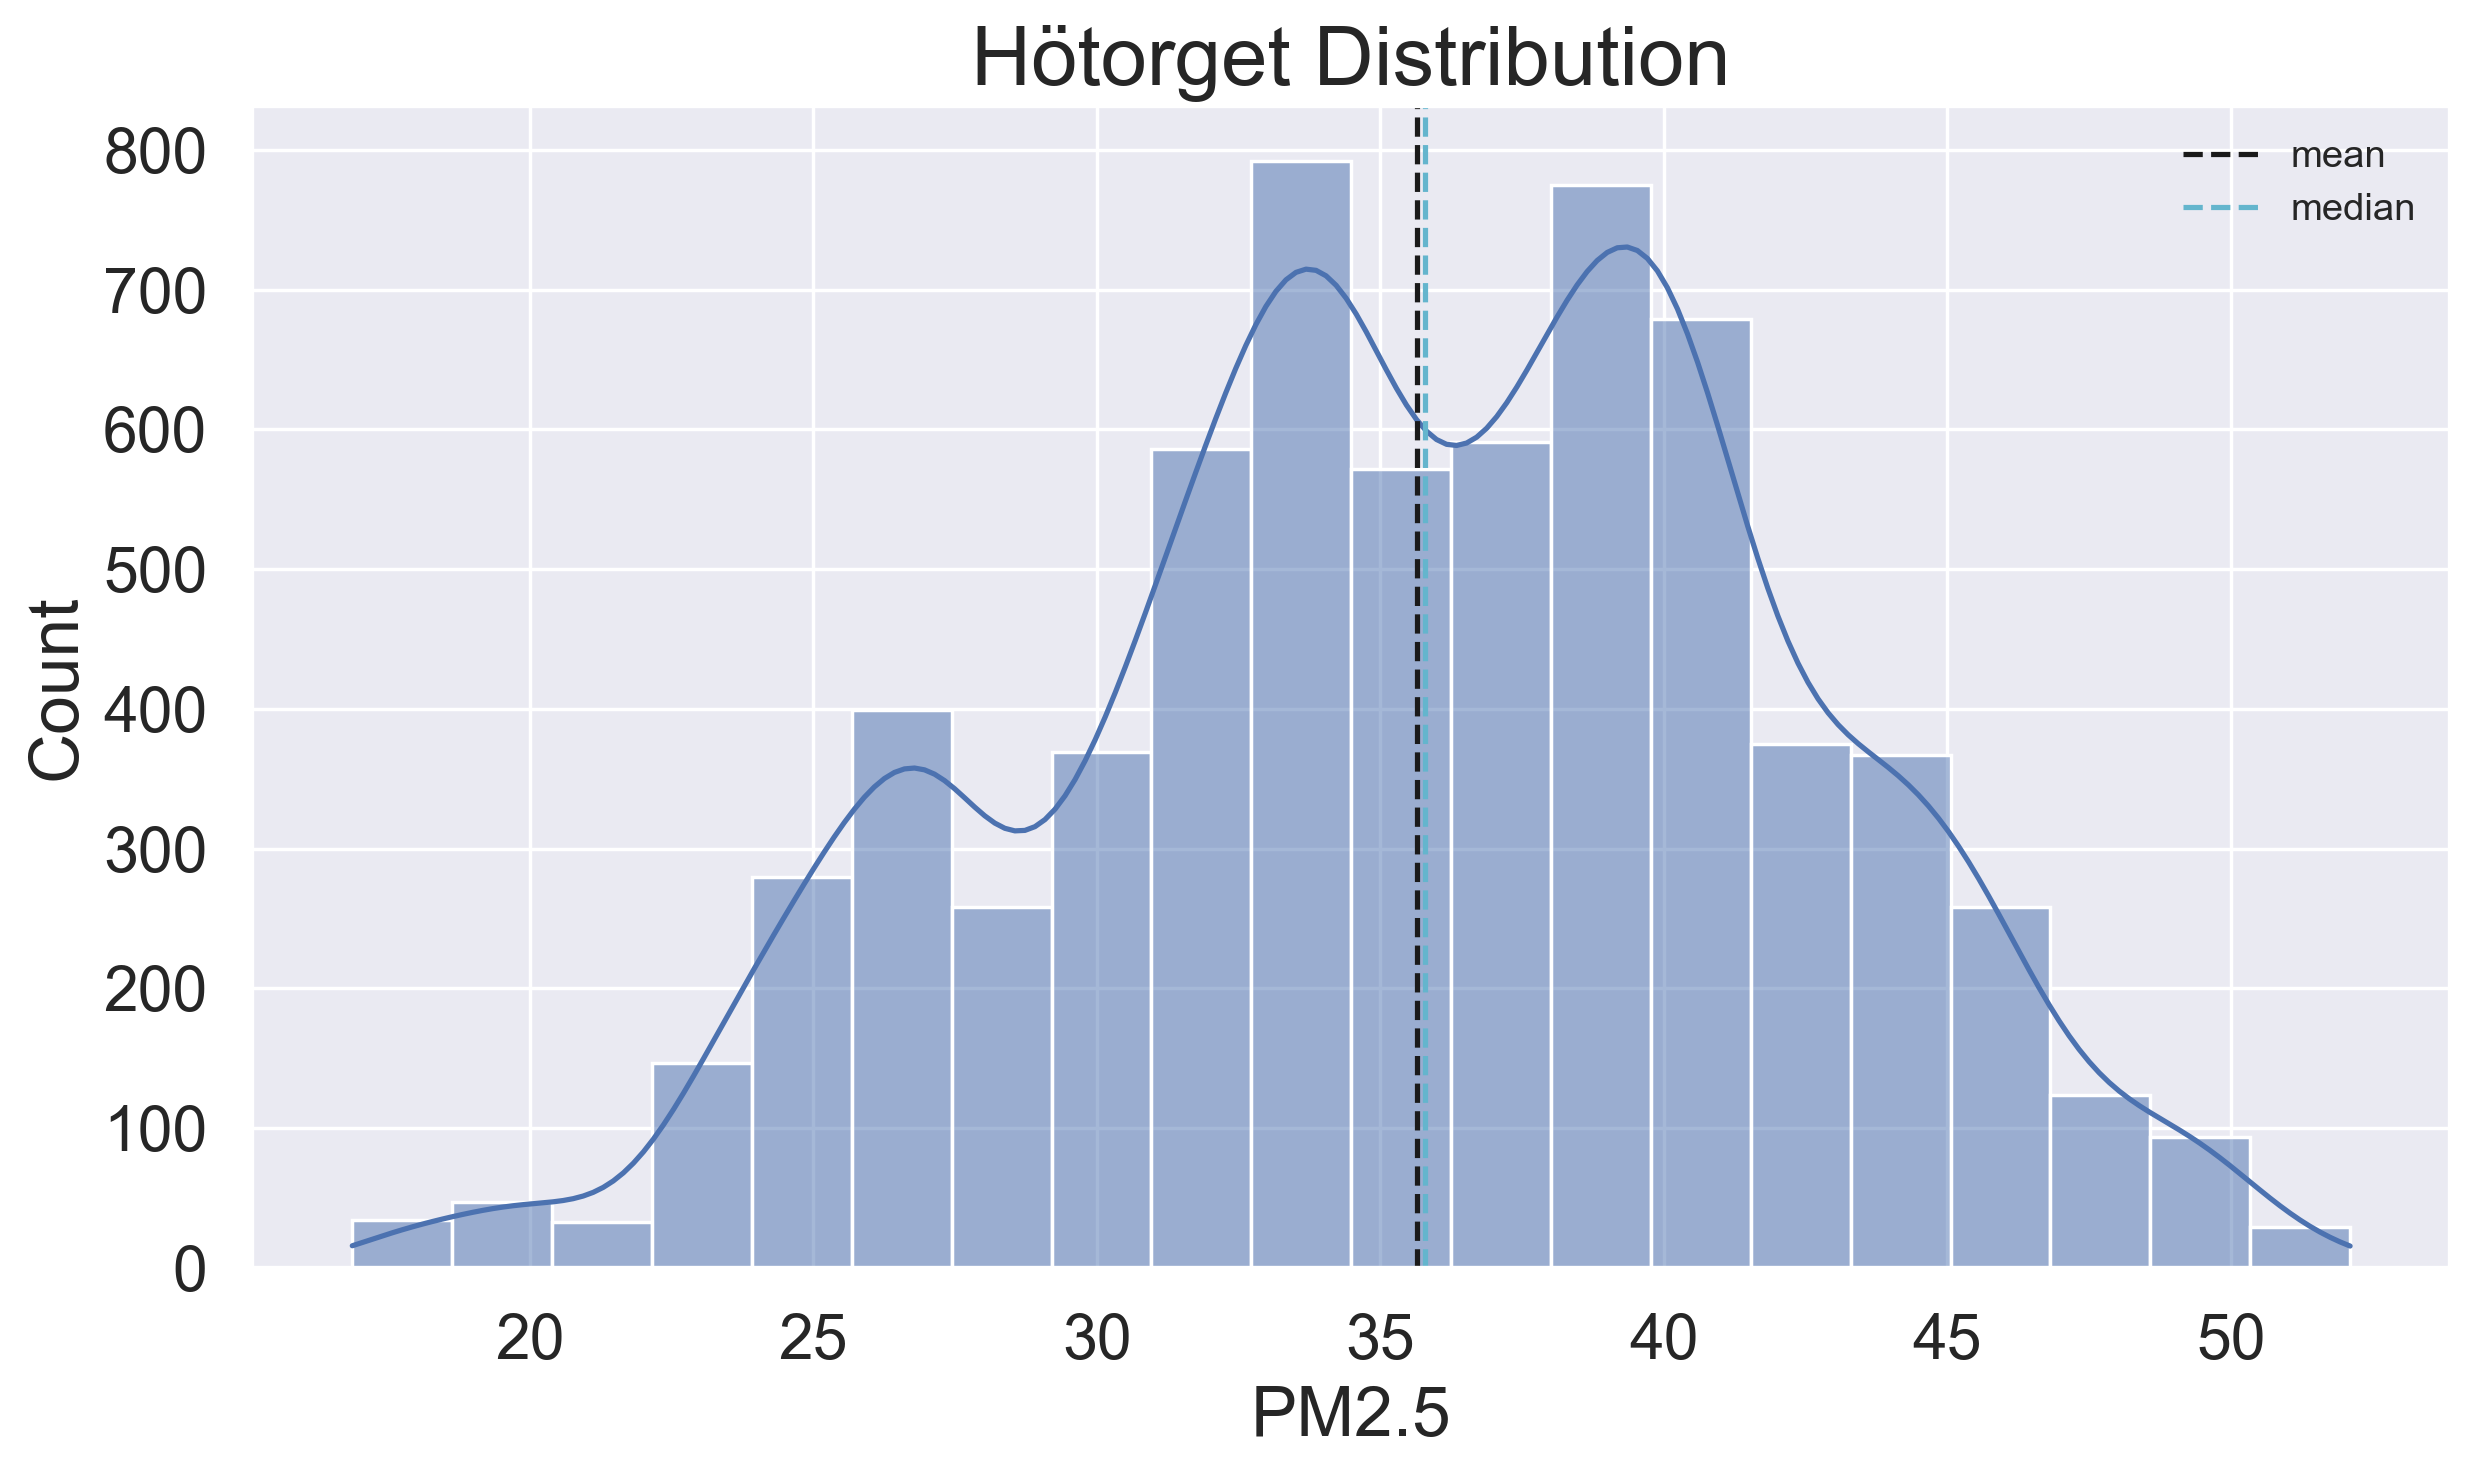

In [179]:
fig, ax = plt.subplots(dpi=250, figsize=[10, 6])

mean = focus_r_df[param].mean()
median = focus_r_df[param].median()
std = sample_std(focus_r_df[param].values)
s_skew = stats.skew(focus_r_df[param], bias=False)
s_kurt = stats.kurtosis(focus_r_df[param], bias=False)

sns.histplot(focus_r_df, x=param, kde=True, bins=20)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_xlabel(param, fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title(f"Hötorget Distribution", fontsize=24)

ax.axvline(mean, c="k", linestyle="--", label="mean")
ax.axvline(median, c="c", linestyle="--", label="median")
ax.legend()
plt.tight_layout()

plt.savefig(f'{fig_folder}/HotorgetDistribution({param}).pdf')

plt.show()

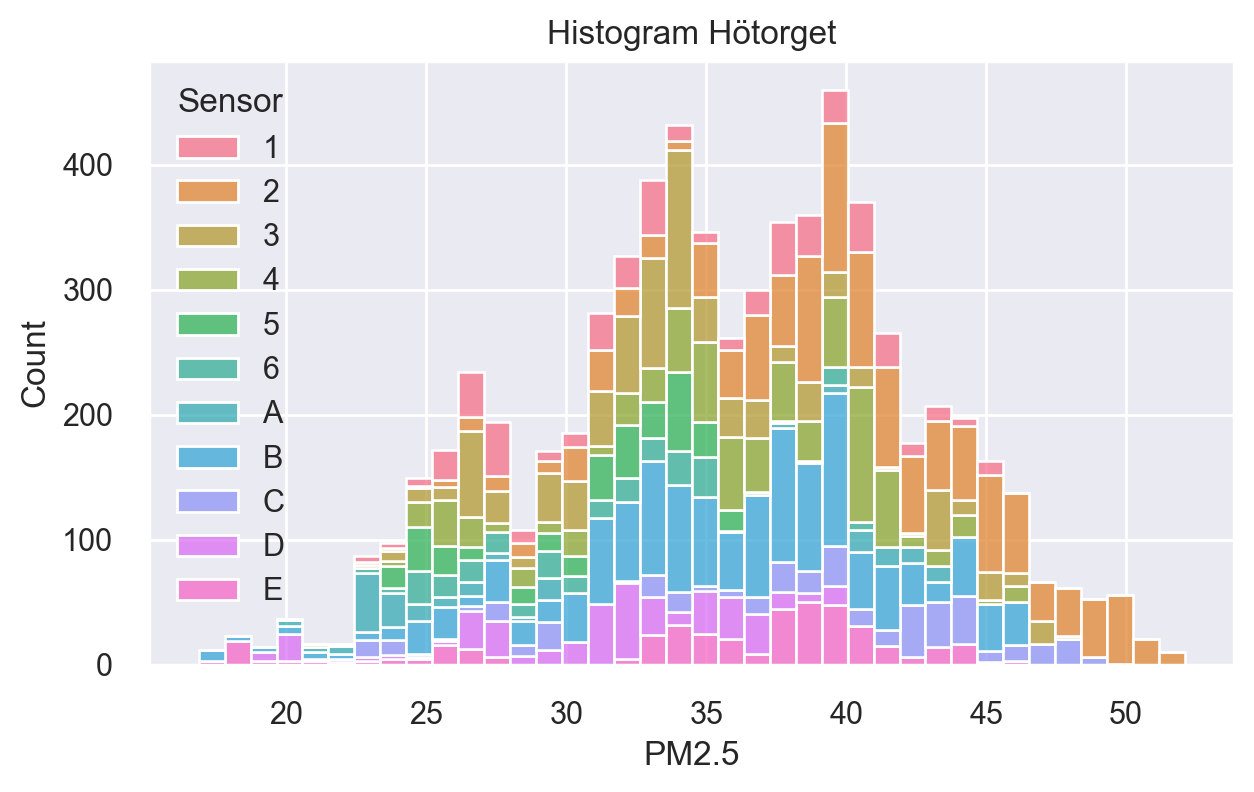

In [374]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', multiple='stack')
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HotorgetHistogram1Sensor({param}).pdf')

plt.show()

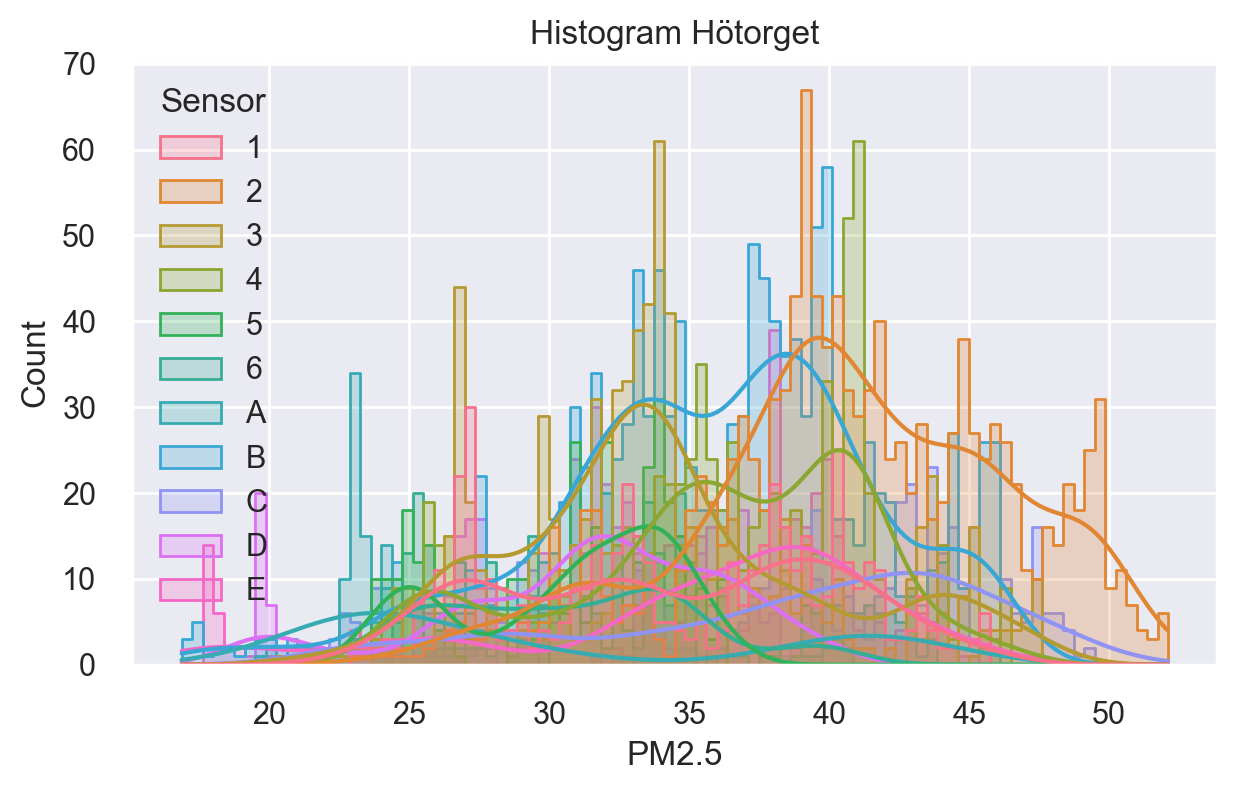

In [373]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', kde=True, element='step', bins=94)
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HotorgetHistogram2Sensor({param}).pdf')

plt.show()

## ANOVA

In [348]:
anova_df = perform_ANOVA(
    focus_r_df,
    param=param,
    alpha=0.1,
)

anova_df

0
SST                              295047.814574
SSW                              227733.968812
SSB                               67313.845762
Alpha                                      0.1
F-stat                              200.935998
F-crit                                1.599657
P-value                                    0.0
F-stat > F-crit  True (Significant Difference)
p-value < alpha  True (Significant Difference)

In [350]:
# Anova per session
anovas = []

for session_id in focus_r_df['Session Id'].unique():
    anova_df = perform_ANOVA(
        focus_r_df[focus_r_df['Session Id'] == session_id],
        param=param,
        alpha=0.1,
    )
    
    anovas.append(anova_df)
    
anovas_df = pd.concat(anovas, axis=1)

anovas_df

0                              0  \
SST                               13605.374747                    6196.595076   
SSW                                8712.067149                    2756.428708   
SSB                                4893.307598                    3440.166367   
Alpha                                      0.1                            0.1   
F-stat                              151.276479                     150.182258   
F-crit                                2.090581                       2.099018   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                                  2691.2475                   10585.000613   
SSW                                 634.886053                    3960.215206   
SSB                                2056.361447                    6624.785408   
Alpha                                      0.1                            0.1   
F-stat                              329.724672                     254.828486   
F-crit                                1.858621                        2.09581   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                                4267.090242                     4121.94123   
SSW                                3492.713385                    3051.142098   
SSB                                 774.376857                    1070.799133   
Alpha                                      0.1                            0.1   
F-stat                               22.171211                      27.900546   
F-crit                                1.958965                       1.962619   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                               11530.251131                      2442.1313   
SSW                                4898.220966                      1124.0321   
SSB                                6632.030165                      1318.0992   
Alpha                                      0.1                            0.1   
F-stat                              165.522481                     152.444842   
F-crit                                1.956389                        2.74452   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                                5142.162075                    2960.138243   
SSW                                3635.176491                     820.278864   
SSB                                1506.985584                    2139.859379   
Alpha                                      0.1                            0.1   
F-stat                               79.387546                     227.608852   
F-crit                                2.316484                       1.961035   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Differ

### Tukey

In [349]:
tukey_df = focus_r_df[[param, 'Sensor']]

tukey = pairwise_tukeyhsd(
    endog=tukey_df[param],
    groups=tukey_df['Sensor'],
    alpha=0.1
)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.10 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2   6.2782  0.001   5.3733  7.1832   True
     1      3  -0.2525    0.9  -1.2237  0.7187  False
     1      4   1.7434  0.001   0.7576  2.7292   True
     1      5  -3.5892  0.001  -4.7928 -2.3856   True
     1      6  -3.4936  0.001  -4.7912 -2.1959   True
     1      A  -4.3594  0.001   -5.756 -2.9628   True
     1      B   1.3455  0.001   0.4425  2.2485   True
     1      C   4.1984  0.001   3.0634  5.3334   True
     1      D  -2.8902  0.001  -4.0259 -1.7545   True
     1      E   0.9564 0.2954  -0.1757  2.0885  False
     2      3  -6.5308  0.001  -7.2973 -5.7643   True
     2      4  -4.5349  0.001  -5.3198 -3.7499   True
     2      5  -9.8674  0.001 -10.9129  -8.822   True
     2      6  -9.7718  0.001 -10.9243 -8.6193   True
     2      A -10.6377  0.001 -11.9005 -9.3748   True
     2      B  -4.9328  0.00

## Systematic Error

How much would the sensors need to be wrong to get the value of 35?

In [178]:
h_mean = focus_s_df[param].mean()
h_std = sample_std(focus_s_df[param].values)

print(f'{round(h_mean, 2)}±{round(h_std, 2)}')

35.5±5.39


In [193]:
# If sensors measure 5microgram per cubic meter
# According to datasheet - ±10 units
# 5 --> max 15 (need to differ with 30.5 units --> 3 times more than datasheet (increase 200%))
# 15 --> max 25 (need to differ with 20.5 units --> 2 times more than datasheet (increase 100%))

# Min value with std: 30.11, still 5 units over

In [194]:
round(h_mean - h_std, 2)

30.11

In [195]:
# 5 barrier
increase = h_mean - 5
prcnt = increase / 10

print(increase)
print(prcnt)

30.500708333333336
3.0500708333333337


In [196]:
# 15 barrier
increase = h_mean - 15
prcnt = increase / 10

print(increase)
print(prcnt)

20.500708333333336
2.0500708333333337


In [197]:
h_mean - 5

30.500708333333336

### Comparison with aboveground measurements

One explanation: a lot of traffic above